In [1]:
import pandas as pd

import numpy as np
from rdkit import Chem
import torch
from torch.utils.data import Dataset

In [2]:
from pom_models.functions import fragance_propabilities_from_smiles

from numpy.linalg import norm

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# MCF imports
from molecule_validation import is_odorant, score_molecule


############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:

def calculate_score(mol, is_vanilla):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return (is_odorant(mol)[0] + score_molecule(mol).all() + is_vanilla)/3

def calculate_score_online(mol):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return int(is_odorant(mol)[0]) + score_molecule(mol).all()

def hard_filter(mol):
    return int(is_odorant(mol)[0]) * score_molecule(mol).all()

### Define dataset

In [5]:
class OpenPOMDataset(Dataset):
    def __init__(self, openpom_file="openpomdata.csv", train=True, split_seed=142857, ratio=0.9):
        df = pd.read_csv(openpom_file).drop("descriptors",axis=1)
        df =  df[df['odorless'] == False]
        df = df[df["nonStereoSMILES"].apply(self.explicit_H_filter)].copy()  
        df = df.reset_index(drop=True)
        df = self.generate_scores(df)
        self.df = df
        rng = np.random.default_rng(split_seed)
        idcs = np.arange(len(self.df))
        rng.shuffle(idcs)
        if train:
            self.idcs = idcs[: int(np.floor(ratio * len(self.df)))]
        else:
            self.idcs = idcs[int(np.floor(ratio * len(self.df))) :]
        self.obj_to_graph = lambda x: x
        self.targets = self.df.keys()[1:]

    def setup(self, task, ctx):
        self.obj_to_graph = ctx.obj_to_graph


    def __len__(self):
        return len(self.idcs)

    def __getitem__(self, idx):
        # Returns the RDkit mol object and corresponding 138 scent labels
        m_smiles = self.df["nonStereoSMILES"][self.idcs[idx]]
        return (
            self.obj_to_graph(Chem.MolFromSmiles(m_smiles)),
            #torch.tensor([self.df[t][self.idcs[idx]] for t in self.targets]).float(),
            #torch.tensor([0.5 if self.df['vanilla'][self.idcs[idx]] == 0 else 1]).float(), # 0.5 reward for non vanilla molecues 1 for vanilla molecules
            #torch.tensor([self.compute_reward_from_smiles(m_smiles)]).float()
            torch.tensor([self.df['score'][self.idcs[idx]]]).float(),
        )
    
    def compute_reward_from_smiles(self, m_smiles):
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            return self.cosine_similarity(TARGET_VEC,m_vec)
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    
    def explicit_H_filter(self, smiles: str) -> bool:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetNumExplicitHs() > 1:
                return False  
        return True
    

    
    def generate_scores(self, df):
        df['score'] = df.apply(
            lambda x: calculate_score(
                Chem.MolFromSmiles(x.nonStereoSMILES), 
                x.vanilla
                ), axis=1)
        return df



In [6]:
from gflownet import GFNTask,LogScalar,ObjectProperties
from gflownet.config import Config,init_empty
from typing import Dict, List, Tuple
from torch import Tensor


In [7]:
class ScentTask(GFNTask):
    def __init__(self, dataset: Dataset, cfg: Config):
        self.dataset = dataset
        self.num_cond_dim = 1
        self.num_objectives = 138

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return {"encoding": torch.ones(n, 1)}

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        #print(obj_props)
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        #print(scalar_logreward)
        return LogScalar(scalar_logreward.flatten())
    
    def compute_obj_properties(self, mols):
        is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,1))), is_valid
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        #scores = torch.tensor([calculate_score_online(m) for m in valid_mols])
        rs = torch.tensor(self.compute_reward_from_mols(valid_mols))
        #rs = (rewards+scores) /3
        return ObjectProperties(rs.reshape((-1, 1))), is_valid 
    
        #Attempt for multible scents
        #flat_r = []
        #for m in mols:
        #    flat_r.append(torch.tensor(fragance_propabilities_from_smiles(Chem.MolToSmiles(m))[0]).float())
        #flat_rewards = torch.stack(flat_r, dim=0)
        #return ObjectProperties(flat_rewards), is_valid
    
    def compute_reward_from_mols(self, mols):
        rewards = []
        for m in mols:
            m_smiles = Chem.MolToSmiles(m)
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            rewards.append(self.cosine_similarity(TARGET_VEC,m_vec))
        return rewards
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

In [8]:
from gflownet.online_trainer import StandardOnlineTrainer
import socket
from gflownet.envs.mol_building_env import MolBuildingEnvContext

In [9]:
class ScentTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.valid_random_action_prob = 0.0
        cfg.num_workers = 8
        cfg.num_training_steps = 100000
        cfg.opt.learning_rate = 1e-6 #1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20000
        cfg.opt.clip_grad_type = "norm"
        cfg.opt.clip_grad_param = 10
        cfg.algo.num_from_policy = 32
        cfg.algo.num_from_dataset = 32
        cfg.algo.train_random_action_prob = 0.001
        cfg.algo.illegal_action_logreward = -75
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #["C", "N", "F", "O"],
            #charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            expl_H_range=[0,1],
            num_cond_dim=self.task.num_cond_dim,
            max_nodes=self.cfg.algo.max_nodes,
        )

    def setup_data(self):
        self.training_data = OpenPOMDataset(train=True)
        self.test_data = OpenPOMDataset(train=False)

    def setup_task(self):
        self.task = ScentTask(dataset=self.training_data,cfg=self.cfg)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task,self.ctx)
        self.test_data.setup(self.task,self.ctx)




In [10]:
import pathlib

In [11]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )


In [12]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/mcf_dataload_2"


# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 
config.validate_every=100
config.algo.valid_num_from_policy= 32
config.algo.valid_num_from_dataset= 32
config.num_training_steps = 300 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1

config.overwrite_existing_exp=True



trial = ScentTrainer(config)
trial.run()
save_run(trial)



Hyperparameters:

desc: noDesc
log_dir: ./logs/mcf_dataload_2
device: cpu
seed: 1
validate_every: 100
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 300
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: e7c59a8
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 32
  valid_num_from_dataset: 32
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr

C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:46:29 - INFO - logger - iteration 1 : offline_loss:5677.40 online_loss:3407.40 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.02 loss:4542.40 n_loss:0.00 tb_loss:4542.40 batch_entropy:52.73 traj_lens:13.28 grad_norm:15388.72 grad_norm_clip:97.42 sampled_reward_avg:0.00 train_time:3.94 time_spent:8.62


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:46:38 - INFO - logger - iteration 2 : offline_loss:3356.85 online_loss:3270.18 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.06 loss:3313.51 n_loss:0.00 tb_loss:3313.51 batch_entropy:53.40 traj_lens:14.42 grad_norm:12832.98 grad_norm_clip:97.77 sampled_reward_avg:0.00 train_time:4.32 time_spent:9.54


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:46:47 - INFO - logger - iteration 3 : offline_loss:20542.10 online_loss:3031.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.04 loss:11786.99 n_loss:0.00 tb_loss:11786.99 batch_entropy:61.15 traj_lens:13.89 grad_norm:22373.35 grad_norm_clip:99.72 sampled_reward_avg:0.00 train_time:3.93 time_spent:8.50


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:46:55 - INFO - logger - iteration 4 : offline_loss:2618.26 online_loss:3228.01 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.05 loss:2923.13 n_loss:0.00 tb_loss:2923.13 batch_entropy:49.18 traj_lens:13.42 grad_norm:10963.33 grad_norm_clip:97.43 sampled_reward_avg:0.00 train_time:3.85 time_spent:8.28


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:47:04 - INFO - logger - iteration 5 : offline_loss:2355.43 online_loss:3267.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.04 loss:2811.43 n_loss:0.00 tb_loss:2811.43 batch_entropy:47.88 traj_lens:13.50 grad_norm:10020.34 grad_norm_clip:97.58 sampled_reward_avg:0.00 train_time:3.69 time_spent:8.86


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:47:13 - INFO - logger - iteration 6 : offline_loss:10804.94 online_loss:3288.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.03 loss:7046.57 n_loss:0.00 tb_loss:7046.57 batch_entropy:60.87 traj_lens:14.14 grad_norm:19339.54 grad_norm_clip:98.93 sampled_reward_avg:0.00 train_time:4.48 time_spent:9.22


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:47:23 - INFO - logger - iteration 7 : offline_loss:2506.69 online_loss:3106.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.02 loss:2806.62 n_loss:0.00 tb_loss:2806.62 batch_entropy:52.75 traj_lens:14.59 grad_norm:10922.42 grad_norm_clip:97.50 sampled_reward_avg:0.00 train_time:4.54 time_spent:9.89


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:47:31 - INFO - logger - iteration 8 : offline_loss:2313.99 online_loss:3710.60 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.01 loss:3012.29 n_loss:0.00 tb_loss:3012.29 batch_entropy:44.16 traj_lens:12.09 grad_norm:10362.80 grad_norm_clip:97.89 sampled_reward_avg:0.00 train_time:3.46 time_spent:7.56


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:47:42 - INFO - logger - iteration 9 : offline_loss:3398.64 online_loss:2969.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.00 loss:3184.19 n_loss:0.00 tb_loss:3184.19 batch_entropy:57.67 traj_lens:15.50 grad_norm:11860.11 grad_norm_clip:97.21 sampled_reward_avg:0.00 train_time:4.90 time_spent:11.02


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:47:53 - INFO - logger - iteration 10 : offline_loss:2506.82 online_loss:2842.24 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.02 loss:2674.53 n_loss:0.00 tb_loss:2674.53 batch_entropy:57.47 traj_lens:16.00 grad_norm:10570.53 grad_norm_clip:97.03 sampled_reward_avg:0.00 train_time:5.46 time_spent:11.63


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:48:06 - INFO - logger - iteration 11 : offline_loss:5750.95 online_loss:2936.14 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.04 loss:4343.54 n_loss:0.00 tb_loss:4343.54 batch_entropy:56.00 traj_lens:14.62 grad_norm:10513.07 grad_norm_clip:97.18 sampled_reward_avg:0.00 train_time:4.70 time_spent:12.19


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:48:15 - INFO - logger - iteration 12 : offline_loss:3714.03 online_loss:3013.46 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.07 loss:3363.75 n_loss:0.00 tb_loss:3363.75 batch_entropy:52.80 traj_lens:13.94 grad_norm:11597.38 grad_norm_clip:96.53 sampled_reward_avg:0.00 train_time:4.39 time_spent:9.27


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:48:22 - INFO - logger - iteration 13 : offline_loss:6046.39 online_loss:3434.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.09 loss:4740.19 n_loss:0.00 tb_loss:4740.19 batch_entropy:53.36 traj_lens:13.19 grad_norm:14954.18 grad_norm_clip:98.19 sampled_reward_avg:0.00 train_time:3.73 time_spent:7.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:48:31 - INFO - logger - iteration 14 : offline_loss:2128.49 online_loss:3535.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.10 loss:2832.19 n_loss:0.00 tb_loss:2832.19 batch_entropy:45.02 traj_lens:12.88 grad_norm:8964.88 grad_norm_clip:97.59 sampled_reward_avg:0.00 train_time:3.57 time_spent:8.76


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:48:41 - INFO - logger - iteration 15 : offline_loss:20258.38 online_loss:3066.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.12 loss:11662.53 n_loss:0.00 tb_loss:11662.53 batch_entropy:61.02 traj_lens:14.03 grad_norm:21915.69 grad_norm_clip:99.53 sampled_reward_avg:0.00 train_time:4.42 time_spent:9.75


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:48:50 - INFO - logger - iteration 16 : offline_loss:2154.96 online_loss:2927.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.13 loss:2541.08 n_loss:0.00 tb_loss:2541.08 batch_entropy:50.71 traj_lens:14.27 grad_norm:9293.63 grad_norm_clip:97.30 sampled_reward_avg:0.00 train_time:4.30 time_spent:9.20


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:00 - INFO - logger - iteration 17 : offline_loss:4959.38 online_loss:3312.44 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.14 loss:4135.91 n_loss:0.00 tb_loss:4135.91 batch_entropy:53.67 traj_lens:13.47 grad_norm:14506.10 grad_norm_clip:97.48 sampled_reward_avg:0.00 train_time:4.14 time_spent:9.74


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:11 - INFO - logger - iteration 18 : offline_loss:2425.76 online_loss:3102.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.15 loss:2764.09 n_loss:0.00 tb_loss:2764.09 batch_entropy:53.93 traj_lens:15.08 grad_norm:10315.30 grad_norm_clip:97.46 sampled_reward_avg:0.00 train_time:4.80 time_spent:11.02


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:20 - INFO - logger - iteration 19 : offline_loss:6286.03 online_loss:2949.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.16 loss:4617.90 n_loss:0.00 tb_loss:4617.90 batch_entropy:56.26 traj_lens:14.58 grad_norm:13512.75 grad_norm_clip:97.74 sampled_reward_avg:0.02 train_time:4.42 time_spent:9.77


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:29 - INFO - logger - iteration 20 : offline_loss:2858.48 online_loss:3157.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.17 loss:3007.91 n_loss:0.00 tb_loss:3007.91 batch_entropy:52.68 traj_lens:14.36 grad_norm:12533.74 grad_norm_clip:97.64 sampled_reward_avg:0.00 train_time:4.22 time_spent:8.95


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:38 - INFO - logger - iteration 21 : offline_loss:23855.59 online_loss:3128.19 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.18 loss:13491.89 n_loss:0.00 tb_loss:13491.89 batch_entropy:66.63 traj_lens:13.75 grad_norm:23385.48 grad_norm_clip:99.82 sampled_reward_avg:0.00 train_time:4.23 time_spent:9.02


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:47 - INFO - logger - iteration 22 : offline_loss:2250.49 online_loss:3512.07 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.18 loss:2881.28 n_loss:0.00 tb_loss:2881.28 batch_entropy:44.63 traj_lens:12.78 grad_norm:8862.21 grad_norm_clip:97.60 sampled_reward_avg:0.00 train_time:3.65 time_spent:8.33


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:49:55 - INFO - logger - iteration 23 : offline_loss:2372.91 online_loss:3360.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.19 loss:2866.59 n_loss:0.00 tb_loss:2866.59 batch_entropy:46.37 traj_lens:12.95 grad_norm:10171.80 grad_norm_clip:97.79 sampled_reward_avg:0.00 train_time:3.62 time_spent:8.62


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:03 - INFO - logger - iteration 24 : offline_loss:2121.23 online_loss:3334.23 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.20 loss:2727.73 n_loss:0.00 tb_loss:2727.73 batch_entropy:44.99 traj_lens:12.45 grad_norm:9046.62 grad_norm_clip:97.53 sampled_reward_avg:0.00 train_time:3.42 time_spent:7.80


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:14 - INFO - logger - iteration 25 : offline_loss:2961.02 online_loss:3054.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.22 loss:3007.79 n_loss:0.00 tb_loss:3007.79 batch_entropy:56.40 traj_lens:15.66 grad_norm:12826.29 grad_norm_clip:97.82 sampled_reward_avg:0.00 train_time:4.84 time_spent:10.40


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:19 - INFO - logger - iteration 26 : offline_loss:8208.73 online_loss:3536.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.23 loss:5872.58 n_loss:0.00 tb_loss:5872.58 batch_entropy:45.41 traj_lens:10.84 grad_norm:13081.83 grad_norm_clip:97.71 sampled_reward_avg:0.00 train_time:2.57 time_spent:5.58


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:26 - INFO - logger - iteration 27 : offline_loss:2816.64 online_loss:3558.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.25 loss:3187.35 n_loss:0.00 tb_loss:3187.35 batch_entropy:45.78 traj_lens:12.70 grad_norm:11444.71 grad_norm_clip:97.97 sampled_reward_avg:0.00 train_time:3.34 time_spent:7.30


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:36 - INFO - logger - iteration 28 : offline_loss:1969.91 online_loss:3164.60 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.27 loss:2567.25 n_loss:0.00 tb_loss:2567.25 batch_entropy:46.86 traj_lens:13.64 grad_norm:8280.38 grad_norm_clip:97.46 sampled_reward_avg:0.00 train_time:3.91 time_spent:9.21


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:48 - INFO - logger - iteration 29 : offline_loss:2954.06 online_loss:2925.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.30 loss:2939.83 n_loss:0.00 tb_loss:2939.83 batch_entropy:60.54 traj_lens:16.66 grad_norm:11616.46 grad_norm_clip:96.54 sampled_reward_avg:0.00 train_time:5.77 time_spent:12.23


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:50:57 - INFO - logger - iteration 30 : offline_loss:6759.36 online_loss:3330.97 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.32 loss:5045.16 n_loss:0.00 tb_loss:5045.16 batch_entropy:54.00 traj_lens:13.53 grad_norm:14483.90 grad_norm_clip:97.21 sampled_reward_avg:0.00 train_time:4.29 time_spent:8.70


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:51:06 - INFO - logger - iteration 31 : offline_loss:2940.12 online_loss:3290.81 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.34 loss:3115.46 n_loss:0.00 tb_loss:3115.46 batch_entropy:49.01 traj_lens:13.72 grad_norm:10681.69 grad_norm_clip:97.48 sampled_reward_avg:0.00 train_time:4.14 time_spent:9.19


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:51:17 - INFO - logger - iteration 32 : offline_loss:10347.95 online_loss:3030.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.36 loss:6689.43 n_loss:0.00 tb_loss:6689.43 batch_entropy:65.71 traj_lens:15.77 grad_norm:18577.51 grad_norm_clip:99.30 sampled_reward_avg:0.00 train_time:5.03 time_spent:11.33


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:51:27 - INFO - logger - iteration 33 : offline_loss:1973.79 online_loss:3050.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.38 loss:2512.19 n_loss:0.00 tb_loss:2512.19 batch_entropy:48.30 traj_lens:13.64 grad_norm:8090.57 grad_norm_clip:97.45 sampled_reward_avg:0.00 train_time:4.03 time_spent:9.38


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:51:35 - INFO - logger - iteration 34 : offline_loss:76700.74 online_loss:3415.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.39 loss:40058.23 n_loss:0.00 tb_loss:40058.23 batch_entropy:69.96 traj_lens:12.77 grad_norm:25089.40 grad_norm_clip:100.39 sampled_reward_avg:0.00 train_time:3.79 time_spent:8.01


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:51:42 - INFO - logger - iteration 35 : offline_loss:2141.56 online_loss:3435.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.40 loss:2788.53 n_loss:0.00 tb_loss:2788.53 batch_entropy:43.40 traj_lens:12.33 grad_norm:8989.97 grad_norm_clip:97.58 sampled_reward_avg:0.00 train_time:3.46 time_spent:7.71


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:51:52 - INFO - logger - iteration 36 : offline_loss:4119.29 online_loss:3165.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.42 loss:3642.28 n_loss:0.00 tb_loss:3642.28 batch_entropy:53.76 traj_lens:14.20 grad_norm:12209.33 grad_norm_clip:96.55 sampled_reward_avg:0.00 train_time:4.38 time_spent:9.46


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:52:00 - INFO - logger - iteration 37 : offline_loss:2073.28 online_loss:3079.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.43 loss:2576.44 n_loss:0.00 tb_loss:2576.44 batch_entropy:46.19 traj_lens:12.94 grad_norm:8523.16 grad_norm_clip:97.51 sampled_reward_avg:0.00 train_time:3.65 time_spent:8.65


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:52:08 - INFO - logger - iteration 38 : offline_loss:20137.75 online_loss:3053.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.45 loss:11595.54 n_loss:0.00 tb_loss:11595.54 batch_entropy:58.18 traj_lens:13.55 grad_norm:16313.06 grad_norm_clip:98.61 sampled_reward_avg:0.00 train_time:3.84 time_spent:7.98


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:52:20 - INFO - logger - iteration 39 : offline_loss:59026.59 online_loss:2890.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.46 loss:30958.30 n_loss:0.00 tb_loss:30958.30 batch_entropy:77.77 traj_lens:16.66 grad_norm:23581.44 grad_norm_clip:100.10 sampled_reward_avg:0.00 train_time:5.31 time_spent:11.27


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:52:31 - INFO - logger - iteration 40 : offline_loss:7190.87 online_loss:3112.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.46 loss:5151.60 n_loss:0.00 tb_loss:5151.60 batch_entropy:63.65 traj_lens:16.03 grad_norm:16363.17 grad_norm_clip:98.90 sampled_reward_avg:0.00 train_time:5.25 time_spent:11.23


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:52:38 - INFO - logger - iteration 41 : offline_loss:2020.80 online_loss:3340.96 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.46 loss:2680.88 n_loss:0.00 tb_loss:2680.88 batch_entropy:42.61 traj_lens:12.12 grad_norm:7267.54 grad_norm_clip:97.18 sampled_reward_avg:0.00 train_time:3.30 time_spent:7.34


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:52:50 - INFO - logger - iteration 42 : offline_loss:2093.47 online_loss:3049.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.47 loss:2571.67 n_loss:0.00 tb_loss:2571.67 batch_entropy:52.77 traj_lens:15.30 grad_norm:8737.01 grad_norm_clip:97.57 sampled_reward_avg:0.00 train_time:5.10 time_spent:11.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:53:00 - INFO - logger - iteration 43 : offline_loss:3330.82 online_loss:3169.38 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:3250.10 n_loss:0.00 tb_loss:3250.10 batch_entropy:49.75 traj_lens:13.55 grad_norm:10373.81 grad_norm_clip:97.36 sampled_reward_avg:0.00 train_time:5.14 time_spent:10.56


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:53:15 - INFO - logger - iteration 44 : offline_loss:4037.03 online_loss:2520.89 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.49 loss:3278.96 n_loss:0.00 tb_loss:3278.96 batch_entropy:66.42 traj_lens:17.56 grad_norm:12816.26 grad_norm_clip:98.03 sampled_reward_avg:0.01 train_time:6.51 time_spent:14.62


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:53:25 - INFO - logger - iteration 45 : offline_loss:30326.04 online_loss:3340.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.49 loss:16833.16 n_loss:0.00 tb_loss:16833.16 batch_entropy:64.26 traj_lens:14.53 grad_norm:21770.23 grad_norm_clip:99.44 sampled_reward_avg:0.00 train_time:4.65 time_spent:10.06


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:53:34 - INFO - logger - iteration 46 : offline_loss:96116.34 online_loss:3068.46 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.50 loss:49592.39 n_loss:0.00 tb_loss:49592.39 batch_entropy:72.74 traj_lens:13.59 grad_norm:22785.99 grad_norm_clip:100.45 sampled_reward_avg:0.00 train_time:4.03 time_spent:9.14


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:53:42 - INFO - logger - iteration 47 : offline_loss:22297.59 online_loss:3413.75 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.49 loss:12855.67 n_loss:0.00 tb_loss:12855.67 batch_entropy:60.86 traj_lens:13.34 grad_norm:18506.65 grad_norm_clip:99.52 sampled_reward_avg:0.00 train_time:3.98 time_spent:8.59


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:53:53 - INFO - logger - iteration 48 : offline_loss:1946.99 online_loss:2691.06 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.49 loss:2319.02 n_loss:0.00 tb_loss:2319.02 batch_entropy:52.34 traj_lens:15.03 grad_norm:8081.96 grad_norm_clip:96.99 sampled_reward_avg:0.00 train_time:4.57 time_spent:10.03


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:02 - INFO - logger - iteration 49 : offline_loss:8242.99 online_loss:3168.52 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:5705.76 n_loss:0.00 tb_loss:5705.76 batch_entropy:57.38 traj_lens:14.16 grad_norm:14214.18 grad_norm_clip:98.15 sampled_reward_avg:0.00 train_time:4.29 time_spent:9.04


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:10 - INFO - logger - iteration 50 : offline_loss:9051.02 online_loss:3309.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:6180.18 n_loss:0.00 tb_loss:6180.18 batch_entropy:49.95 traj_lens:12.59 grad_norm:14100.54 grad_norm_clip:97.60 sampled_reward_avg:0.00 train_time:3.74 time_spent:8.05


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:19 - INFO - logger - iteration 51 : offline_loss:2362.79 online_loss:3133.06 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:2747.93 n_loss:0.00 tb_loss:2747.93 batch_entropy:46.48 traj_lens:13.44 grad_norm:8889.81 grad_norm_clip:97.65 sampled_reward_avg:0.00 train_time:3.82 time_spent:9.05


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:28 - INFO - logger - iteration 52 : offline_loss:13783.09 online_loss:3138.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:8460.98 n_loss:0.00 tb_loss:8460.98 batch_entropy:59.14 traj_lens:14.38 grad_norm:15829.53 grad_norm_clip:98.72 sampled_reward_avg:0.00 train_time:4.45 time_spent:9.23


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:38 - INFO - logger - iteration 53 : offline_loss:2667.36 online_loss:2878.49 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:2772.93 n_loss:0.00 tb_loss:2772.93 batch_entropy:53.03 traj_lens:14.89 grad_norm:10286.12 grad_norm_clip:97.25 sampled_reward_avg:0.00 train_time:4.47 time_spent:9.82


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:47 - INFO - logger - iteration 54 : offline_loss:1961.14 online_loss:2772.64 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:2366.89 n_loss:0.00 tb_loss:2366.89 batch_entropy:49.33 traj_lens:13.89 grad_norm:8349.58 grad_norm_clip:97.23 sampled_reward_avg:0.00 train_time:4.02 time_spent:8.82


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:54:55 - INFO - logger - iteration 55 : offline_loss:2178.24 online_loss:3430.71 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.48 loss:2804.47 n_loss:0.00 tb_loss:2804.47 batch_entropy:45.19 traj_lens:13.27 grad_norm:9553.24 grad_norm_clip:97.79 sampled_reward_avg:0.00 train_time:3.98 time_spent:8.86


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:55:05 - INFO - logger - iteration 56 : offline_loss:2391.88 online_loss:2994.13 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.49 loss:2693.01 n_loss:0.00 tb_loss:2693.01 batch_entropy:51.70 traj_lens:14.45 grad_norm:9033.72 grad_norm_clip:97.39 sampled_reward_avg:0.00 train_time:4.36 time_spent:9.78


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:55:14 - INFO - logger - iteration 57 : offline_loss:15767.53 online_loss:3088.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.51 loss:9428.20 n_loss:0.00 tb_loss:9428.20 batch_entropy:64.15 traj_lens:13.62 grad_norm:20979.23 grad_norm_clip:100.00 sampled_reward_avg:0.01 train_time:4.16 time_spent:8.66


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:55:22 - INFO - logger - iteration 58 : offline_loss:1712.85 online_loss:3119.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.51 loss:2416.24 n_loss:0.00 tb_loss:2416.24 batch_entropy:43.04 traj_lens:12.62 grad_norm:7305.51 grad_norm_clip:97.27 sampled_reward_avg:0.00 train_time:3.49 time_spent:8.01


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:55:32 - INFO - logger - iteration 59 : offline_loss:3064.50 online_loss:2813.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.52 loss:2938.88 n_loss:0.00 tb_loss:2938.88 batch_entropy:56.16 traj_lens:15.39 grad_norm:11213.14 grad_norm_clip:96.32 sampled_reward_avg:0.00 train_time:4.75 time_spent:10.25


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:55:43 - INFO - logger - iteration 60 : offline_loss:2470.50 online_loss:3098.99 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.53 loss:2784.75 n_loss:0.00 tb_loss:2784.75 batch_entropy:51.55 traj_lens:14.88 grad_norm:9237.76 grad_norm_clip:97.59 sampled_reward_avg:0.00 train_time:4.61 time_spent:11.16


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:55:52 - INFO - logger - iteration 61 : offline_loss:3149.18 online_loss:2840.01 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.55 loss:2994.59 n_loss:0.00 tb_loss:2994.59 batch_entropy:49.98 traj_lens:14.05 grad_norm:9122.06 grad_norm_clip:96.88 sampled_reward_avg:0.01 train_time:3.94 time_spent:9.17


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:00 - INFO - logger - iteration 62 : offline_loss:1971.30 online_loss:3256.99 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.56 loss:2614.14 n_loss:0.00 tb_loss:2614.14 batch_entropy:44.55 traj_lens:12.97 grad_norm:8705.03 grad_norm_clip:97.43 sampled_reward_avg:0.00 train_time:3.52 time_spent:7.90


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:11 - INFO - logger - iteration 63 : offline_loss:5704.45 online_loss:2870.47 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.58 loss:4287.46 n_loss:0.00 tb_loss:4287.46 batch_entropy:58.94 traj_lens:15.39 grad_norm:12733.78 grad_norm_clip:96.81 sampled_reward_avg:0.00 train_time:4.92 time_spent:10.55


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:19 - INFO - logger - iteration 64 : offline_loss:4246.79 online_loss:3692.30 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.60 loss:3969.54 n_loss:0.00 tb_loss:3969.54 batch_entropy:44.06 traj_lens:12.00 grad_norm:10133.11 grad_norm_clip:97.74 sampled_reward_avg:0.00 train_time:3.20 time_spent:7.70


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:30 - INFO - logger - iteration 65 : offline_loss:4133.56 online_loss:3097.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.61 loss:3615.59 n_loss:0.00 tb_loss:3615.59 batch_entropy:57.05 traj_lens:15.48 grad_norm:12398.40 grad_norm_clip:97.23 sampled_reward_avg:0.00 train_time:5.17 time_spent:10.94


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:40 - INFO - logger - iteration 66 : offline_loss:21502.14 online_loss:2689.02 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.63 loss:12095.58 n_loss:0.00 tb_loss:12095.58 batch_entropy:67.99 traj_lens:15.34 grad_norm:15499.07 grad_norm_clip:98.86 sampled_reward_avg:0.00 train_time:5.00 time_spent:10.83


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:49 - INFO - logger - iteration 67 : offline_loss:3308.53 online_loss:3274.23 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.64 loss:3291.38 n_loss:0.00 tb_loss:3291.38 batch_entropy:48.76 traj_lens:13.62 grad_norm:10598.84 grad_norm_clip:97.55 sampled_reward_avg:0.00 train_time:4.02 time_spent:8.76


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:56:58 - INFO - logger - iteration 68 : offline_loss:2058.95 online_loss:3166.67 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.66 loss:2612.81 n_loss:0.00 tb_loss:2612.81 batch_entropy:47.72 traj_lens:13.67 grad_norm:8523.21 grad_norm_clip:97.47 sampled_reward_avg:0.00 train_time:4.04 time_spent:9.15


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:57:07 - INFO - logger - iteration 69 : offline_loss:1903.41 online_loss:2998.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.68 loss:2450.87 n_loss:0.00 tb_loss:2450.87 batch_entropy:46.24 traj_lens:13.53 grad_norm:7770.68 grad_norm_clip:97.30 sampled_reward_avg:0.00 train_time:3.78 time_spent:8.73


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:57:15 - INFO - logger - iteration 70 : offline_loss:6048.97 online_loss:3014.99 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.69 loss:4531.98 n_loss:0.00 tb_loss:4531.98 batch_entropy:52.35 traj_lens:13.61 grad_norm:12765.04 grad_norm_clip:97.77 sampled_reward_avg:0.00 train_time:3.84 time_spent:8.44


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:57:23 - INFO - logger - iteration 71 : offline_loss:4214.25 online_loss:3371.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.71 loss:3792.97 n_loss:0.00 tb_loss:3792.97 batch_entropy:45.96 traj_lens:12.47 grad_norm:10574.49 grad_norm_clip:97.68 sampled_reward_avg:0.00 train_time:3.26 time_spent:7.34


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:57:32 - INFO - logger - iteration 72 : offline_loss:2089.59 online_loss:3136.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.72 loss:2613.23 n_loss:0.00 tb_loss:2613.23 batch_entropy:48.65 traj_lens:14.20 grad_norm:8523.31 grad_norm_clip:97.49 sampled_reward_avg:0.00 train_time:4.18 time_spent:9.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:57:43 - INFO - logger - iteration 73 : offline_loss:4475.52 online_loss:2919.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.74 loss:3697.64 n_loss:0.00 tb_loss:3697.64 batch_entropy:53.14 traj_lens:14.31 grad_norm:11084.90 grad_norm_clip:96.62 sampled_reward_avg:0.02 train_time:4.53 time_spent:10.40


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:57:52 - INFO - logger - iteration 74 : offline_loss:1855.39 online_loss:3035.37 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.76 loss:2445.38 n_loss:0.00 tb_loss:2445.38 batch_entropy:48.56 traj_lens:14.27 grad_norm:7861.74 grad_norm_clip:97.63 sampled_reward_avg:0.00 train_time:4.36 time_spent:9.89


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:00 - INFO - logger - iteration 75 : offline_loss:1934.68 online_loss:2816.12 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.78 loss:2375.40 n_loss:0.00 tb_loss:2375.40 batch_entropy:46.90 traj_lens:13.39 grad_norm:8403.86 grad_norm_clip:97.31 sampled_reward_avg:0.00 train_time:3.73 time_spent:7.84


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:10 - INFO - logger - iteration 76 : offline_loss:19010.46 online_loss:3146.09 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.81 loss:11078.27 n_loss:0.00 tb_loss:11078.27 batch_entropy:65.76 traj_lens:14.58 grad_norm:19425.84 grad_norm_clip:100.11 sampled_reward_avg:0.00 train_time:4.67 time_spent:9.81


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:17 - INFO - logger - iteration 77 : offline_loss:2105.37 online_loss:3444.21 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.82 loss:2774.79 n_loss:0.00 tb_loss:2774.79 batch_entropy:41.39 traj_lens:11.97 grad_norm:8724.14 grad_norm_clip:97.54 sampled_reward_avg:0.00 train_time:3.08 time_spent:6.91


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:25 - INFO - logger - iteration 78 : offline_loss:1988.25 online_loss:3253.35 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.84 loss:2620.80 n_loss:0.00 tb_loss:2620.80 batch_entropy:43.75 traj_lens:12.72 grad_norm:7853.51 grad_norm_clip:97.30 sampled_reward_avg:0.00 train_time:3.64 time_spent:8.20


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:32 - INFO - logger - iteration 79 : offline_loss:19726.12 online_loss:3362.08 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.86 loss:11544.10 n_loss:0.00 tb_loss:11544.10 batch_entropy:53.31 traj_lens:12.02 grad_norm:16530.88 grad_norm_clip:98.93 sampled_reward_avg:0.00 train_time:3.29 time_spent:7.24


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:42 - INFO - logger - iteration 80 : offline_loss:9569.85 online_loss:2772.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.88 loss:6171.38 n_loss:0.00 tb_loss:6171.38 batch_entropy:58.91 traj_lens:14.70 grad_norm:15425.85 grad_norm_clip:99.07 sampled_reward_avg:0.00 train_time:4.71 time_spent:9.76


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:51 - INFO - logger - iteration 81 : offline_loss:1805.63 online_loss:3207.22 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.89 loss:2506.42 n_loss:0.00 tb_loss:2506.42 batch_entropy:44.73 traj_lens:12.80 grad_norm:7385.80 grad_norm_clip:97.13 sampled_reward_avg:0.00 train_time:3.91 time_spent:8.72


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:58:59 - INFO - logger - iteration 82 : offline_loss:135597.56 online_loss:3276.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.90 loss:69436.95 n_loss:0.00 tb_loss:69436.95 batch_entropy:76.47 traj_lens:13.11 grad_norm:38721.18 grad_norm_clip:100.43 sampled_reward_avg:0.00 train_time:4.23 time_spent:8.56


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:59:11 - INFO - logger - iteration 83 : offline_loss:5634.28 online_loss:2729.40 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.90 loss:4181.84 n_loss:0.00 tb_loss:4181.84 batch_entropy:60.13 traj_lens:16.41 grad_norm:10703.70 grad_norm_clip:97.48 sampled_reward_avg:0.00 train_time:5.28 time_spent:11.98


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:59:21 - INFO - logger - iteration 84 : offline_loss:16301.54 online_loss:2934.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.91 loss:9618.06 n_loss:0.00 tb_loss:9618.06 batch_entropy:60.20 traj_lens:14.39 grad_norm:12825.84 grad_norm_clip:98.36 sampled_reward_avg:0.00 train_time:4.39 time_spent:9.31


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:59:30 - INFO - logger - iteration 85 : offline_loss:3062.03 online_loss:2966.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.90 loss:3014.29 n_loss:0.00 tb_loss:3014.29 batch_entropy:49.08 traj_lens:13.84 grad_norm:9394.64 grad_norm_clip:97.55 sampled_reward_avg:0.00 train_time:4.15 time_spent:9.29


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:59:37 - INFO - logger - iteration 86 : offline_loss:2153.97 online_loss:3249.92 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.90 loss:2701.94 n_loss:0.00 tb_loss:2701.94 batch_entropy:41.27 traj_lens:11.81 grad_norm:8091.92 grad_norm_clip:97.58 sampled_reward_avg:0.01 train_time:3.23 time_spent:7.24


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:59:50 - INFO - logger - iteration 87 : offline_loss:12176.35 online_loss:2465.73 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.91 loss:7321.04 n_loss:0.00 tb_loss:7321.04 batch_entropy:70.77 traj_lens:17.12 grad_norm:15326.10 grad_norm_clip:99.30 sampled_reward_avg:0.00 train_time:5.55 time_spent:12.29


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 12:59:59 - INFO - logger - iteration 88 : offline_loss:15501.50 online_loss:3055.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.91 loss:9278.53 n_loss:0.00 tb_loss:9278.53 batch_entropy:66.69 traj_lens:14.73 grad_norm:18482.19 grad_norm_clip:100.00 sampled_reward_avg:0.00 train_time:4.83 time_spent:9.67


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:00:08 - INFO - logger - iteration 89 : offline_loss:2118.22 online_loss:3045.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.91 loss:2582.04 n_loss:0.00 tb_loss:2582.04 batch_entropy:47.40 traj_lens:14.05 grad_norm:8864.57 grad_norm_clip:97.45 sampled_reward_avg:0.00 train_time:4.07 time_spent:8.70


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:00:17 - INFO - logger - iteration 90 : offline_loss:1800.84 online_loss:2853.28 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.91 loss:2327.06 n_loss:0.00 tb_loss:2327.06 batch_entropy:47.33 traj_lens:14.12 grad_norm:7420.53 grad_norm_clip:96.97 sampled_reward_avg:0.00 train_time:4.13 time_spent:9.12


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:00:26 - INFO - logger - iteration 91 : offline_loss:1875.29 online_loss:2944.61 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.91 loss:2409.95 n_loss:0.00 tb_loss:2409.95 batch_entropy:47.82 traj_lens:13.94 grad_norm:7715.26 grad_norm_clip:97.10 sampled_reward_avg:0.00 train_time:4.18 time_spent:9.18


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:00:34 - INFO - logger - iteration 92 : offline_loss:2303.35 online_loss:3195.80 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.92 loss:2749.57 n_loss:0.00 tb_loss:2749.57 batch_entropy:46.10 traj_lens:13.61 grad_norm:9548.24 grad_norm_clip:97.59 sampled_reward_avg:0.00 train_time:3.76 time_spent:8.07


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:00:43 - INFO - logger - iteration 93 : offline_loss:1710.65 online_loss:3072.96 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.93 loss:2391.80 n_loss:0.00 tb_loss:2391.80 batch_entropy:44.86 traj_lens:13.31 grad_norm:6657.16 grad_norm_clip:96.77 sampled_reward_avg:0.00 train_time:3.95 time_spent:9.02


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:00:53 - INFO - logger - iteration 94 : offline_loss:33311.61 online_loss:2984.94 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.95 loss:18148.28 n_loss:0.00 tb_loss:18148.28 batch_entropy:64.77 traj_lens:14.59 grad_norm:25667.25 grad_norm_clip:99.17 sampled_reward_avg:0.00 train_time:4.65 time_spent:9.43


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:01:05 - INFO - logger - iteration 95 : offline_loss:22104.32 online_loss:2749.84 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.96 loss:12427.09 n_loss:0.00 tb_loss:12427.09 batch_entropy:70.33 traj_lens:16.31 grad_norm:15882.45 grad_norm_clip:99.50 sampled_reward_avg:0.00 train_time:5.55 time_spent:11.99


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:01:15 - INFO - logger - iteration 96 : offline_loss:3160.71 online_loss:3004.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.96 loss:3082.35 n_loss:0.00 tb_loss:3082.35 batch_entropy:51.12 traj_lens:14.33 grad_norm:9017.59 grad_norm_clip:97.47 sampled_reward_avg:0.00 train_time:4.58 time_spent:10.19


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:01:23 - INFO - logger - iteration 97 : offline_loss:2061.34 online_loss:3120.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.97 loss:2591.06 n_loss:0.00 tb_loss:2591.06 batch_entropy:44.67 traj_lens:13.31 grad_norm:7414.21 grad_norm_clip:97.08 sampled_reward_avg:0.00 train_time:3.73 time_spent:8.55


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:01:34 - INFO - logger - iteration 98 : offline_loss:2121.82 online_loss:2808.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.98 loss:2465.32 n_loss:0.00 tb_loss:2465.32 batch_entropy:52.39 traj_lens:15.25 grad_norm:7730.72 grad_norm_clip:96.83 sampled_reward_avg:0.00 train_time:4.58 time_spent:10.07


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:01:45 - INFO - logger - iteration 99 : offline_loss:4025.43 online_loss:2761.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.99 loss:3393.38 n_loss:0.00 tb_loss:3393.38 batch_entropy:57.19 traj_lens:15.59 grad_norm:10532.26 grad_norm_clip:97.57 sampled_reward_avg:0.01 train_time:5.21 time_spent:11.23


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:01:54 - INFO - logger - iteration 100 : offline_loss:1905.85 online_loss:2932.46 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.00 loss:2419.15 n_loss:0.00 tb_loss:2419.15 batch_entropy:46.21 traj_lens:13.80 grad_norm:7734.43 grad_norm_clip:97.16 sampled_reward_avg:0.01 train_time:4.21 time_spent:8.74


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:02:02 - INFO - logger - validation - iteration 100 : offline_loss:2005.32 online_loss:2791.36 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.01 loss:2398.34 n_loss:0.00 tb_loss:2398.34 batch_entropy:54.84 traj_lens:16.12 sampled_reward_avg:0.00 eval_time:1.82


c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 13:02:04 - INFO - logger - validation - iteration 100 : offline_loss:15880.04 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.01 loss:15880.04 n_loss:0.00 tb_loss:15880.04 batch_entropy:88.56 traj_lens:17.38 eval_time:0.97
15/04/2025 13:02:06 - INFO - logger - validation - iteration 100 : offline_loss:1610.76 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.01 loss:1610.76 n_loss:0.00 tb_loss:1610.76 batch_entropy:57.19 traj_lens:15.28 eval_time:0.95
15/04/2025 13:02:08 - INFO - logger - validation - iteration 100 : offline_loss:2019.43 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.01 loss:2019.43 n_loss:0.00 tb_loss:2019.43 batch_entropy:63.04 traj_lens:16.84 eval_time:0.91
15/04/2025 13:02:10 - INFO - logger - validation - iter

C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:02:38 - INFO - logger - iteration 101 : offline_loss:5522.24 online_loss:3028.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.01 loss:4275.47 n_loss:0.00 tb_loss:4275.47 batch_entropy:52.33 traj_lens:14.14 grad_norm:10477.15 grad_norm_clip:97.06 sampled_reward_avg:0.00 train_time:4.50 time_spent:44.94


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:02:47 - INFO - logger - iteration 102 : offline_loss:1255.19 online_loss:2772.61 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.03 loss:2013.90 n_loss:0.00 tb_loss:2013.90 batch_entropy:43.11 traj_lens:13.17 grad_norm:4716.29 grad_norm_clip:94.85 sampled_reward_avg:0.00 train_time:3.70 time_spent:8.59


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:02:58 - INFO - logger - iteration 103 : offline_loss:5149.23 online_loss:2899.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.04 loss:4024.39 n_loss:0.00 tb_loss:4024.39 batch_entropy:52.57 traj_lens:14.27 grad_norm:10223.13 grad_norm_clip:96.01 sampled_reward_avg:0.02 train_time:4.49 time_spent:10.61


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:03:07 - INFO - logger - iteration 104 : offline_loss:3242.40 online_loss:3106.83 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.06 loss:3174.61 n_loss:0.00 tb_loss:3174.61 batch_entropy:48.74 traj_lens:13.89 grad_norm:9561.49 grad_norm_clip:97.52 sampled_reward_avg:0.00 train_time:4.26 time_spent:8.97


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:03:19 - INFO - logger - iteration 105 : offline_loss:5320.00 online_loss:2842.29 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.08 loss:4081.15 n_loss:0.00 tb_loss:4081.15 batch_entropy:59.30 traj_lens:15.84 grad_norm:10702.99 grad_norm_clip:96.47 sampled_reward_avg:0.00 train_time:5.67 time_spent:12.08


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:03:29 - INFO - logger - iteration 106 : offline_loss:3903.33 online_loss:2804.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.10 loss:3353.83 n_loss:0.00 tb_loss:3353.83 batch_entropy:56.76 traj_lens:15.55 grad_norm:10736.50 grad_norm_clip:97.40 sampled_reward_avg:0.00 train_time:5.10 time_spent:10.08


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:03:38 - INFO - logger - iteration 107 : offline_loss:1619.92 online_loss:2838.18 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.11 loss:2229.05 n_loss:0.00 tb_loss:2229.05 batch_entropy:46.63 traj_lens:13.89 grad_norm:6227.26 grad_norm_clip:96.50 sampled_reward_avg:0.00 train_time:4.25 time_spent:9.57


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:03:49 - INFO - logger - iteration 108 : offline_loss:2247.41 online_loss:2334.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.12 loss:2290.84 n_loss:0.00 tb_loss:2290.84 batch_entropy:55.61 traj_lens:15.92 grad_norm:7288.64 grad_norm_clip:96.16 sampled_reward_avg:0.00 train_time:4.87 time_spent:11.08


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:03:57 - INFO - logger - iteration 109 : offline_loss:1732.27 online_loss:3143.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.14 loss:2437.98 n_loss:0.00 tb_loss:2437.98 batch_entropy:42.72 traj_lens:12.72 grad_norm:6804.93 grad_norm_clip:96.82 sampled_reward_avg:0.00 train_time:3.52 time_spent:7.53


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:04:09 - INFO - logger - iteration 110 : offline_loss:27087.31 online_loss:2704.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.16 loss:14895.83 n_loss:0.00 tb_loss:14895.83 batch_entropy:77.54 traj_lens:16.84 grad_norm:21033.36 grad_norm_clip:100.44 sampled_reward_avg:0.00 train_time:5.91 time_spent:12.21


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:04:19 - INFO - logger - iteration 111 : offline_loss:2632.67 online_loss:2969.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.17 loss:2801.00 n_loss:0.00 tb_loss:2801.00 batch_entropy:48.96 traj_lens:13.98 grad_norm:7882.33 grad_norm_clip:97.16 sampled_reward_avg:0.00 train_time:4.35 time_spent:9.33


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:04:29 - INFO - logger - iteration 112 : offline_loss:2025.97 online_loss:2886.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.19 loss:2456.37 n_loss:0.00 tb_loss:2456.37 batch_entropy:50.58 traj_lens:14.92 grad_norm:7865.13 grad_norm_clip:96.76 sampled_reward_avg:0.00 train_time:4.93 time_spent:10.66


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:04:38 - INFO - logger - iteration 113 : offline_loss:3803.98 online_loss:2876.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.21 loss:3340.25 n_loss:0.00 tb_loss:3340.25 batch_entropy:49.78 traj_lens:13.42 grad_norm:9849.42 grad_norm_clip:96.31 sampled_reward_avg:0.02 train_time:3.98 time_spent:8.53


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:04:46 - INFO - logger - iteration 114 : offline_loss:1679.37 online_loss:2956.17 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.23 loss:2317.77 n_loss:0.00 tb_loss:2317.77 batch_entropy:45.87 traj_lens:13.83 grad_norm:6721.65 grad_norm_clip:96.39 sampled_reward_avg:0.00 train_time:4.09 time_spent:8.38


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:04:56 - INFO - logger - iteration 115 : offline_loss:99209.47 online_loss:2940.30 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.25 loss:51074.88 n_loss:0.00 tb_loss:51074.88 batch_entropy:76.84 traj_lens:14.69 grad_norm:24495.90 grad_norm_clip:101.00 sampled_reward_avg:0.00 train_time:5.06 time_spent:10.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:05:07 - INFO - logger - iteration 116 : offline_loss:19069.99 online_loss:2782.94 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.26 loss:10926.46 n_loss:0.00 tb_loss:10926.46 batch_entropy:60.32 traj_lens:14.84 grad_norm:12588.57 grad_norm_clip:98.19 sampled_reward_avg:0.00 train_time:4.94 time_spent:10.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:05:17 - INFO - logger - iteration 117 : offline_loss:2772.12 online_loss:2598.85 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.27 loss:2685.48 n_loss:0.00 tb_loss:2685.48 batch_entropy:56.44 traj_lens:15.58 grad_norm:9500.44 grad_norm_clip:95.91 sampled_reward_avg:0.00 train_time:4.95 time_spent:10.72


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:05:26 - INFO - logger - iteration 118 : offline_loss:2126.19 online_loss:3176.04 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.28 loss:2651.11 n_loss:0.00 tb_loss:2651.11 batch_entropy:43.99 traj_lens:12.66 grad_norm:7271.00 grad_norm_clip:97.39 sampled_reward_avg:0.00 train_time:3.82 time_spent:8.32


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:05:36 - INFO - logger - iteration 119 : offline_loss:4908.77 online_loss:2214.14 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.29 loss:3561.45 n_loss:0.00 tb_loss:3561.45 batch_entropy:58.79 traj_lens:16.03 grad_norm:8817.55 grad_norm_clip:97.21 sampled_reward_avg:0.01 train_time:4.84 time_spent:10.36


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:05:45 - INFO - logger - iteration 120 : offline_loss:1909.64 online_loss:3040.03 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.29 loss:2474.84 n_loss:0.00 tb_loss:2474.84 batch_entropy:45.19 traj_lens:13.09 grad_norm:6952.40 grad_norm_clip:97.03 sampled_reward_avg:0.00 train_time:4.05 time_spent:8.79


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:05:56 - INFO - logger - iteration 121 : offline_loss:2091.19 online_loss:2703.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.30 loss:2397.45 n_loss:0.00 tb_loss:2397.45 batch_entropy:53.96 traj_lens:15.67 grad_norm:7288.43 grad_norm_clip:96.65 sampled_reward_avg:0.00 train_time:5.09 time_spent:11.42


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:06:07 - INFO - logger - iteration 122 : offline_loss:1649.76 online_loss:2493.31 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.31 loss:2071.54 n_loss:0.00 tb_loss:2071.54 batch_entropy:52.61 traj_lens:15.48 grad_norm:6461.94 grad_norm_clip:96.26 sampled_reward_avg:0.00 train_time:5.10 time_spent:10.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:06:18 - INFO - logger - iteration 123 : offline_loss:62450.80 online_loss:2533.02 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.33 loss:32491.91 n_loss:0.00 tb_loss:32491.91 batch_entropy:74.96 traj_lens:15.97 grad_norm:33420.45 grad_norm_clip:100.62 sampled_reward_avg:0.00 train_time:5.30 time_spent:10.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:06:29 - INFO - logger - iteration 124 : offline_loss:1597.81 online_loss:2651.47 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.34 loss:2124.64 n_loss:0.00 tb_loss:2124.64 batch_entropy:53.90 traj_lens:16.11 grad_norm:5960.50 grad_norm_clip:95.85 sampled_reward_avg:0.00 train_time:5.15 time_spent:11.19


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:06:41 - INFO - logger - iteration 125 : offline_loss:6821.66 online_loss:2761.08 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.36 loss:4791.37 n_loss:0.00 tb_loss:4791.37 batch_entropy:55.55 traj_lens:15.36 grad_norm:10092.97 grad_norm_clip:97.47 sampled_reward_avg:0.02 train_time:4.83 time_spent:11.05


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:06:51 - INFO - logger - iteration 126 : offline_loss:8106.21 online_loss:2746.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.37 loss:5426.54 n_loss:0.00 tb_loss:5426.54 batch_entropy:56.55 traj_lens:15.34 grad_norm:10179.63 grad_norm_clip:96.44 sampled_reward_avg:0.00 train_time:4.77 time_spent:10.52


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:07:01 - INFO - logger - iteration 127 : offline_loss:1741.48 online_loss:2902.16 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.37 loss:2321.82 n_loss:0.00 tb_loss:2321.82 batch_entropy:48.29 traj_lens:14.34 grad_norm:6858.87 grad_norm_clip:96.91 sampled_reward_avg:0.00 train_time:4.61 time_spent:10.14


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:07:13 - INFO - logger - iteration 128 : offline_loss:1999.73 online_loss:2578.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.39 loss:2289.22 n_loss:0.00 tb_loss:2289.22 batch_entropy:55.95 traj_lens:16.80 grad_norm:7074.70 grad_norm_clip:96.62 sampled_reward_avg:0.00 train_time:5.57 time_spent:11.74


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:07:23 - INFO - logger - iteration 129 : offline_loss:12407.89 online_loss:2963.94 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.40 loss:7685.91 n_loss:0.00 tb_loss:7685.91 batch_entropy:55.33 traj_lens:14.06 grad_norm:11557.14 grad_norm_clip:97.96 sampled_reward_avg:0.00 train_time:4.39 time_spent:9.87


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:07:34 - INFO - logger - iteration 130 : offline_loss:2927.75 online_loss:2757.54 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.41 loss:2842.64 n_loss:0.00 tb_loss:2842.64 batch_entropy:55.13 traj_lens:15.84 grad_norm:7733.03 grad_norm_clip:96.86 sampled_reward_avg:0.00 train_time:5.09 time_spent:10.79


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:07:44 - INFO - logger - iteration 131 : offline_loss:1777.98 online_loss:2740.12 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.43 loss:2259.05 n_loss:0.00 tb_loss:2259.05 batch_entropy:50.70 traj_lens:14.94 grad_norm:7352.17 grad_norm_clip:96.54 sampled_reward_avg:0.02 train_time:4.73 time_spent:10.10


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:07:52 - INFO - logger - iteration 132 : offline_loss:1625.84 online_loss:3056.71 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.45 loss:2341.27 n_loss:0.00 tb_loss:2341.27 batch_entropy:43.74 traj_lens:13.14 grad_norm:6055.79 grad_norm_clip:96.35 sampled_reward_avg:0.00 train_time:4.03 time_spent:8.66


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:08:06 - INFO - logger - iteration 133 : offline_loss:5028.73 online_loss:2662.02 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.47 loss:3845.37 n_loss:0.00 tb_loss:3845.37 batch_entropy:62.53 traj_lens:17.14 grad_norm:10230.92 grad_norm_clip:97.86 sampled_reward_avg:0.00 train_time:6.32 time_spent:13.20


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:08:15 - INFO - logger - iteration 134 : offline_loss:2518.54 online_loss:3121.89 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.48 loss:2820.21 n_loss:0.00 tb_loss:2820.21 batch_entropy:47.30 traj_lens:13.91 grad_norm:7900.01 grad_norm_clip:97.87 sampled_reward_avg:0.00 train_time:4.56 time_spent:9.93


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:08:27 - INFO - logger - iteration 135 : offline_loss:1709.69 online_loss:2312.98 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.50 loss:2011.34 n_loss:0.00 tb_loss:2011.34 batch_entropy:54.75 traj_lens:16.12 grad_norm:6884.58 grad_norm_clip:96.27 sampled_reward_avg:0.01 train_time:5.15 time_spent:11.29


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:08:34 - INFO - logger - iteration 136 : offline_loss:1627.96 online_loss:2998.86 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.52 loss:2313.41 n_loss:0.00 tb_loss:2313.41 batch_entropy:41.73 traj_lens:12.95 grad_norm:6202.97 grad_norm_clip:96.79 sampled_reward_avg:0.00 train_time:3.50 time_spent:7.54


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:08:44 - INFO - logger - iteration 137 : offline_loss:29714.29 online_loss:2838.90 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.54 loss:16276.59 n_loss:0.00 tb_loss:16276.59 batch_entropy:61.68 traj_lens:14.58 grad_norm:14785.75 grad_norm_clip:98.72 sampled_reward_avg:0.00 train_time:4.35 time_spent:9.47


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:08:54 - INFO - logger - iteration 138 : offline_loss:1671.41 online_loss:2833.86 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.56 loss:2252.63 n_loss:0.00 tb_loss:2252.63 batch_entropy:46.97 traj_lens:14.30 grad_norm:6489.91 grad_norm_clip:96.66 sampled_reward_avg:0.00 train_time:4.37 time_spent:9.82


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:09:04 - INFO - logger - iteration 139 : offline_loss:6164.63 online_loss:2881.45 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.58 loss:4523.04 n_loss:0.00 tb_loss:4523.04 batch_entropy:55.65 traj_lens:15.23 grad_norm:9408.54 grad_norm_clip:96.33 sampled_reward_avg:0.00 train_time:4.85 time_spent:10.48


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:09:15 - INFO - logger - iteration 140 : offline_loss:2602.77 online_loss:2595.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.60 loss:2599.32 n_loss:0.00 tb_loss:2599.32 batch_entropy:53.08 traj_lens:15.33 grad_norm:6542.13 grad_norm_clip:96.88 sampled_reward_avg:0.00 train_time:5.02 time_spent:10.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:09:25 - INFO - logger - iteration 141 : offline_loss:1890.05 online_loss:2395.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.62 loss:2142.98 n_loss:0.00 tb_loss:2142.98 batch_entropy:52.46 traj_lens:15.11 grad_norm:5904.99 grad_norm_clip:96.20 sampled_reward_avg:0.00 train_time:4.58 time_spent:10.04


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:09:36 - INFO - logger - iteration 142 : offline_loss:5825.90 online_loss:2875.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.64 loss:4350.66 n_loss:0.00 tb_loss:4350.66 batch_entropy:55.62 traj_lens:15.06 grad_norm:11139.00 grad_norm_clip:97.84 sampled_reward_avg:0.02 train_time:4.74 time_spent:11.21


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:09:46 - INFO - logger - iteration 143 : offline_loss:3547.46 online_loss:2654.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.66 loss:3101.08 n_loss:0.00 tb_loss:3101.08 batch_entropy:52.24 traj_lens:15.02 grad_norm:7989.98 grad_norm_clip:96.66 sampled_reward_avg:0.00 train_time:4.73 time_spent:9.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:09:57 - INFO - logger - iteration 144 : offline_loss:81647.62 online_loss:2739.23 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.68 loss:42193.43 n_loss:0.00 tb_loss:42193.43 batch_entropy:77.97 traj_lens:15.69 grad_norm:23742.95 grad_norm_clip:101.00 sampled_reward_avg:0.02 train_time:5.28 time_spent:11.22


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:10:08 - INFO - logger - iteration 145 : offline_loss:1575.77 online_loss:2442.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.69 loss:2009.17 n_loss:0.00 tb_loss:2009.17 batch_entropy:53.80 traj_lens:16.00 grad_norm:6057.38 grad_norm_clip:95.62 sampled_reward_avg:0.00 train_time:4.89 time_spent:10.66


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:10:18 - INFO - logger - iteration 146 : offline_loss:1408.53 online_loss:2950.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.71 loss:2179.64 n_loss:0.00 tb_loss:2179.64 batch_entropy:43.23 traj_lens:13.58 grad_norm:5203.21 grad_norm_clip:96.06 sampled_reward_avg:0.00 train_time:3.80 time_spent:9.44


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:10:27 - INFO - logger - iteration 147 : offline_loss:2036.88 online_loss:2916.25 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.73 loss:2476.57 n_loss:0.00 tb_loss:2476.57 batch_entropy:46.50 traj_lens:13.98 grad_norm:6516.79 grad_norm_clip:96.72 sampled_reward_avg:0.00 train_time:4.35 time_spent:9.13


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:10:35 - INFO - logger - iteration 148 : offline_loss:2529.57 online_loss:2861.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.75 loss:2695.69 n_loss:0.00 tb_loss:2695.69 batch_entropy:45.01 traj_lens:13.17 grad_norm:7131.32 grad_norm_clip:96.88 sampled_reward_avg:0.01 train_time:3.64 time_spent:7.93


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:10:45 - INFO - logger - iteration 149 : offline_loss:1519.88 online_loss:2439.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.78 loss:1979.88 n_loss:0.00 tb_loss:1979.88 batch_entropy:50.53 traj_lens:15.06 grad_norm:5728.07 grad_norm_clip:95.78 sampled_reward_avg:0.01 train_time:4.56 time_spent:10.01


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:10:56 - INFO - logger - iteration 150 : offline_loss:1742.04 online_loss:2400.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.80 loss:2071.39 n_loss:0.00 tb_loss:2071.39 batch_entropy:56.96 traj_lens:16.69 grad_norm:6266.36 grad_norm_clip:96.23 sampled_reward_avg:0.01 train_time:5.49 time_spent:11.62


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:11:08 - INFO - logger - iteration 151 : offline_loss:2388.66 online_loss:2532.71 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.84 loss:2460.69 n_loss:0.00 tb_loss:2460.69 batch_entropy:56.58 traj_lens:16.33 grad_norm:7528.13 grad_norm_clip:96.35 sampled_reward_avg:0.00 train_time:5.48 time_spent:11.81


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:11:19 - INFO - logger - iteration 152 : offline_loss:1516.00 online_loss:2096.61 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.87 loss:1806.31 n_loss:0.00 tb_loss:1806.31 batch_entropy:55.85 traj_lens:16.58 grad_norm:5231.73 grad_norm_clip:94.87 sampled_reward_avg:0.00 train_time:5.35 time_spent:11.12


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:11:29 - INFO - logger - iteration 153 : offline_loss:1778.00 online_loss:2824.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.90 loss:2301.22 n_loss:0.00 tb_loss:2301.22 batch_entropy:47.52 traj_lens:14.78 grad_norm:6165.11 grad_norm_clip:96.62 sampled_reward_avg:0.00 train_time:4.62 time_spent:9.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:11:41 - INFO - logger - iteration 154 : offline_loss:3731.30 online_loss:2564.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.94 loss:3147.86 n_loss:0.00 tb_loss:3147.86 batch_entropy:58.21 traj_lens:16.58 grad_norm:7643.04 grad_norm_clip:96.46 sampled_reward_avg:0.00 train_time:5.65 time_spent:11.94


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:11:50 - INFO - logger - iteration 155 : offline_loss:2195.33 online_loss:2858.30 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.97 loss:2526.81 n_loss:0.00 tb_loss:2526.81 batch_entropy:46.96 traj_lens:13.83 grad_norm:7445.17 grad_norm_clip:96.99 sampled_reward_avg:0.00 train_time:4.09 time_spent:9.12


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:12:01 - INFO - logger - iteration 156 : offline_loss:2262.24 online_loss:2447.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.01 loss:2355.07 n_loss:0.00 tb_loss:2355.07 batch_entropy:54.55 traj_lens:16.31 grad_norm:7158.24 grad_norm_clip:96.35 sampled_reward_avg:0.00 train_time:5.14 time_spent:10.43


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:12:11 - INFO - logger - iteration 157 : offline_loss:1897.90 online_loss:2618.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.05 loss:2258.25 n_loss:0.00 tb_loss:2258.25 batch_entropy:49.61 traj_lens:14.81 grad_norm:6293.65 grad_norm_clip:96.26 sampled_reward_avg:0.00 train_time:4.74 time_spent:10.28


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:12:21 - INFO - logger - iteration 158 : offline_loss:8457.29 online_loss:2529.73 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.09 loss:5493.51 n_loss:0.00 tb_loss:5493.51 batch_entropy:55.42 traj_lens:14.45 grad_norm:9732.81 grad_norm_clip:98.13 sampled_reward_avg:0.02 train_time:4.66 time_spent:9.56


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:12:32 - INFO - logger - iteration 159 : offline_loss:1597.83 online_loss:2567.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.12 loss:2082.71 n_loss:0.00 tb_loss:2082.71 batch_entropy:52.21 traj_lens:15.69 grad_norm:6091.94 grad_norm_clip:96.17 sampled_reward_avg:0.00 train_time:5.19 time_spent:11.60


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:12:44 - INFO - logger - iteration 160 : offline_loss:77096.70 online_loss:2468.31 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.15 loss:39782.50 n_loss:0.00 tb_loss:39782.50 batch_entropy:76.64 traj_lens:15.75 grad_norm:19865.95 grad_norm_clip:100.74 sampled_reward_avg:0.00 train_time:5.52 time_spent:11.89


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:12:53 - INFO - logger - iteration 161 : offline_loss:1827.04 online_loss:2774.52 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.18 loss:2300.78 n_loss:0.00 tb_loss:2300.78 batch_entropy:46.83 traj_lens:14.28 grad_norm:5658.44 grad_norm_clip:96.44 sampled_reward_avg:0.00 train_time:4.36 time_spent:9.37


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:13:03 - INFO - logger - iteration 162 : offline_loss:1780.73 online_loss:2691.41 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.20 loss:2236.07 n_loss:0.00 tb_loss:2236.07 batch_entropy:49.08 traj_lens:14.97 grad_norm:6807.08 grad_norm_clip:96.75 sampled_reward_avg:0.00 train_time:4.66 time_spent:10.00


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:13:13 - INFO - logger - iteration 163 : offline_loss:62227.20 online_loss:2884.65 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.23 loss:32555.93 n_loss:0.00 tb_loss:32555.93 batch_entropy:69.81 traj_lens:14.70 grad_norm:34401.44 grad_norm_clip:101.00 sampled_reward_avg:0.00 train_time:4.94 time_spent:9.91


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:13:23 - INFO - logger - iteration 164 : offline_loss:3696.40 online_loss:2979.79 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.26 loss:3338.09 n_loss:0.00 tb_loss:3338.09 batch_entropy:47.33 traj_lens:13.98 grad_norm:7397.20 grad_norm_clip:97.14 sampled_reward_avg:0.00 train_time:3.96 time_spent:9.26


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:13:35 - INFO - logger - iteration 165 : offline_loss:38352.42 online_loss:2326.28 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.28 loss:20339.35 n_loss:0.00 tb_loss:20339.35 batch_entropy:71.83 traj_lens:16.95 grad_norm:13508.43 grad_norm_clip:99.45 sampled_reward_avg:0.00 train_time:6.13 time_spent:12.67


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:13:44 - INFO - logger - iteration 166 : offline_loss:1478.33 online_loss:2672.66 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.30 loss:2075.50 n_loss:0.00 tb_loss:2075.50 batch_entropy:45.53 traj_lens:14.00 grad_norm:5377.57 grad_norm_clip:95.55 sampled_reward_avg:0.02 train_time:4.24 time_spent:9.27


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:13:52 - INFO - logger - iteration 167 : offline_loss:7230.85 online_loss:2820.96 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.31 loss:5025.90 n_loss:0.00 tb_loss:5025.90 batch_entropy:49.79 traj_lens:13.16 grad_norm:9342.36 grad_norm_clip:97.37 sampled_reward_avg:0.01 train_time:3.72 time_spent:7.54


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:14:02 - INFO - logger - iteration 168 : offline_loss:1750.61 online_loss:2718.39 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.33 loss:2234.50 n_loss:0.00 tb_loss:2234.50 batch_entropy:47.92 traj_lens:14.64 grad_norm:6373.98 grad_norm_clip:96.58 sampled_reward_avg:0.00 train_time:4.48 time_spent:9.89


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:14:15 - INFO - logger - iteration 169 : offline_loss:1714.12 online_loss:2231.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.34 loss:1972.81 n_loss:0.00 tb_loss:1972.81 batch_entropy:58.50 traj_lens:17.33 grad_norm:5606.72 grad_norm_clip:95.57 sampled_reward_avg:0.02 train_time:6.23 time_spent:13.58


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:14:25 - INFO - logger - iteration 170 : offline_loss:1718.48 online_loss:2492.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.36 loss:2105.50 n_loss:0.00 tb_loss:2105.50 batch_entropy:49.38 traj_lens:14.69 grad_norm:6106.25 grad_norm_clip:95.53 sampled_reward_avg:0.02 train_time:4.46 time_spent:9.44


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:14:34 - INFO - logger - iteration 171 : offline_loss:1397.45 online_loss:2914.14 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.39 loss:2155.80 n_loss:0.00 tb_loss:2155.80 batch_entropy:43.83 traj_lens:13.66 grad_norm:5194.58 grad_norm_clip:95.49 sampled_reward_avg:0.00 train_time:4.00 time_spent:8.85


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:14:48 - INFO - logger - iteration 172 : offline_loss:3765.39 online_loss:1927.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.41 loss:2846.36 n_loss:0.00 tb_loss:2846.36 batch_entropy:65.96 traj_lens:18.34 grad_norm:7561.39 grad_norm_clip:97.29 sampled_reward_avg:0.00 train_time:6.53 time_spent:13.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:14:56 - INFO - logger - iteration 173 : offline_loss:1264.63 online_loss:2748.84 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.43 loss:2006.74 n_loss:0.00 tb_loss:2006.74 batch_entropy:42.41 traj_lens:13.41 grad_norm:4254.42 grad_norm_clip:94.62 sampled_reward_avg:0.00 train_time:3.75 time_spent:8.40


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:15:09 - INFO - logger - iteration 174 : offline_loss:1388.80 online_loss:2157.14 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.46 loss:1772.97 n_loss:0.00 tb_loss:1772.97 batch_entropy:54.19 traj_lens:16.52 grad_norm:4860.48 grad_norm_clip:94.61 sampled_reward_avg:0.02 train_time:5.50 time_spent:12.39


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:15:18 - INFO - logger - iteration 175 : offline_loss:1471.01 online_loss:2558.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.48 loss:2014.72 n_loss:0.00 tb_loss:2014.72 batch_entropy:47.92 traj_lens:14.73 grad_norm:5055.37 grad_norm_clip:95.17 sampled_reward_avg:0.00 train_time:4.36 time_spent:9.61


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:15:35 - INFO - logger - iteration 176 : offline_loss:194236.36 online_loss:2218.19 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.51 loss:98227.27 n_loss:0.00 tb_loss:98227.27 batch_entropy:101.18 traj_lens:18.69 grad_norm:92688.62 grad_norm_clip:101.00 sampled_reward_avg:0.00 train_time:7.90 time_spent:16.70


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:15:46 - INFO - logger - iteration 177 : offline_loss:2130.92 online_loss:2458.96 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.53 loss:2294.94 n_loss:0.00 tb_loss:2294.94 batch_entropy:55.20 traj_lens:16.41 grad_norm:6741.78 grad_norm_clip:96.16 sampled_reward_avg:0.00 train_time:5.59 time_spent:11.67


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:15:58 - INFO - logger - iteration 178 : offline_loss:25598.58 online_loss:2202.39 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.56 loss:13900.49 n_loss:0.00 tb_loss:13900.49 batch_entropy:73.97 traj_lens:16.05 grad_norm:16993.99 grad_norm_clip:100.58 sampled_reward_avg:0.04 train_time:5.56 time_spent:11.52


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:16:08 - INFO - logger - iteration 179 : offline_loss:9054.59 online_loss:2659.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.57 loss:5857.14 n_loss:0.00 tb_loss:5857.14 batch_entropy:54.85 traj_lens:14.69 grad_norm:9082.49 grad_norm_clip:97.43 sampled_reward_avg:0.00 train_time:4.74 time_spent:10.21


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:16:20 - INFO - logger - iteration 180 : offline_loss:1989.89 online_loss:2560.04 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.58 loss:2274.97 n_loss:0.00 tb_loss:2274.97 batch_entropy:52.39 traj_lens:15.64 grad_norm:6246.12 grad_norm_clip:96.02 sampled_reward_avg:0.01 train_time:5.21 time_spent:11.61


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:16:30 - INFO - logger - iteration 181 : offline_loss:4187.41 online_loss:2399.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.59 loss:3293.21 n_loss:0.00 tb_loss:3293.21 batch_entropy:54.58 traj_lens:15.47 grad_norm:7970.31 grad_norm_clip:96.83 sampled_reward_avg:0.00 train_time:4.84 time_spent:10.24


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:16:43 - INFO - logger - iteration 182 : offline_loss:2989.52 online_loss:2198.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.60 loss:2594.22 n_loss:0.00 tb_loss:2594.22 batch_entropy:59.73 traj_lens:17.52 grad_norm:7442.56 grad_norm_clip:95.85 sampled_reward_avg:0.00 train_time:6.01 time_spent:12.57


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:16:51 - INFO - logger - iteration 183 : offline_loss:1630.44 online_loss:2827.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.60 loss:2228.88 n_loss:0.00 tb_loss:2228.88 batch_entropy:42.06 traj_lens:12.97 grad_norm:5023.80 grad_norm_clip:95.34 sampled_reward_avg:0.00 train_time:3.68 time_spent:8.21


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:17:05 - INFO - logger - iteration 184 : offline_loss:3076.86 online_loss:2417.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.62 loss:2747.32 n_loss:0.00 tb_loss:2747.32 batch_entropy:60.54 traj_lens:17.30 grad_norm:6499.56 grad_norm_clip:95.61 sampled_reward_avg:0.00 train_time:6.54 time_spent:13.85


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:17:14 - INFO - logger - iteration 185 : offline_loss:1347.87 online_loss:2684.53 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.62 loss:2016.20 n_loss:0.00 tb_loss:2016.20 batch_entropy:44.13 traj_lens:14.00 grad_norm:4691.67 grad_norm_clip:94.78 sampled_reward_avg:0.01 train_time:4.17 time_spent:9.14


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:17:24 - INFO - logger - iteration 186 : offline_loss:1504.51 online_loss:2533.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.63 loss:2018.92 n_loss:0.00 tb_loss:2018.92 batch_entropy:48.53 traj_lens:14.98 grad_norm:5508.19 grad_norm_clip:96.24 sampled_reward_avg:0.00 train_time:4.87 time_spent:10.44


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:17:37 - INFO - logger - iteration 187 : offline_loss:1910.91 online_loss:2097.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.65 loss:2004.06 n_loss:0.00 tb_loss:2004.06 batch_entropy:57.71 traj_lens:17.38 grad_norm:6246.62 grad_norm_clip:95.34 sampled_reward_avg:0.02 train_time:6.09 time_spent:12.84


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:17:48 - INFO - logger - iteration 188 : offline_loss:1363.81 online_loss:2449.48 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.67 loss:1906.64 n_loss:0.00 tb_loss:1906.64 batch_entropy:47.57 traj_lens:14.67 grad_norm:4877.69 grad_norm_clip:94.95 sampled_reward_avg:0.00 train_time:4.60 time_spent:10.70


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:17:59 - INFO - logger - iteration 189 : offline_loss:2650.03 online_loss:2261.64 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.69 loss:2455.83 n_loss:0.00 tb_loss:2455.83 batch_entropy:54.60 traj_lens:15.97 grad_norm:6074.29 grad_norm_clip:95.98 sampled_reward_avg:0.00 train_time:5.12 time_spent:10.77


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:18:06 - INFO - logger - iteration 190 : offline_loss:1839.77 online_loss:2902.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.71 loss:2371.17 n_loss:0.00 tb_loss:2371.17 batch_entropy:40.89 traj_lens:12.50 grad_norm:5653.22 grad_norm_clip:96.00 sampled_reward_avg:0.00 train_time:3.28 time_spent:7.07


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:18:18 - INFO - logger - iteration 191 : offline_loss:3383.39 online_loss:1992.89 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.74 loss:2688.14 n_loss:0.00 tb_loss:2688.14 batch_entropy:59.81 traj_lens:17.50 grad_norm:5894.52 grad_norm_clip:94.96 sampled_reward_avg:0.00 train_time:5.96 time_spent:12.74


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:18:27 - INFO - logger - iteration 192 : offline_loss:1734.41 online_loss:2895.60 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.76 loss:2315.01 n_loss:0.00 tb_loss:2315.01 batch_entropy:43.08 traj_lens:13.25 grad_norm:5320.08 grad_norm_clip:96.10 sampled_reward_avg:0.00 train_time:3.96 time_spent:8.89


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:18:40 - INFO - logger - iteration 193 : offline_loss:1592.91 online_loss:2282.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.79 loss:1937.81 n_loss:0.00 tb_loss:1937.81 batch_entropy:55.05 traj_lens:16.88 grad_norm:5277.27 grad_norm_clip:95.41 sampled_reward_avg:0.00 train_time:6.02 time_spent:13.17


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:18:53 - INFO - logger - iteration 194 : offline_loss:14772.82 online_loss:2067.93 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.82 loss:8420.37 n_loss:0.00 tb_loss:8420.37 batch_entropy:65.20 traj_lens:17.34 grad_norm:9354.07 grad_norm_clip:98.18 sampled_reward_avg:0.00 train_time:5.96 time_spent:12.39


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:19:07 - INFO - logger - iteration 195 : offline_loss:1769.20 online_loss:2110.55 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.84 loss:1939.87 n_loss:0.00 tb_loss:1939.87 batch_entropy:61.32 traj_lens:18.42 grad_norm:6271.45 grad_norm_clip:94.87 sampled_reward_avg:0.00 train_time:6.69 time_spent:13.92


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:19:17 - INFO - logger - iteration 196 : offline_loss:1644.64 online_loss:2668.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.87 loss:2156.48 n_loss:0.00 tb_loss:2156.48 batch_entropy:46.41 traj_lens:14.31 grad_norm:5018.35 grad_norm_clip:95.03 sampled_reward_avg:0.00 train_time:4.69 time_spent:10.47


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:19:33 - INFO - logger - iteration 197 : offline_loss:1741.35 online_loss:1827.81 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.89 loss:1784.58 n_loss:0.00 tb_loss:1784.58 batch_entropy:65.07 traj_lens:19.42 grad_norm:5148.24 grad_norm_clip:93.78 sampled_reward_avg:0.00 train_time:7.33 time_spent:15.53


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:19:43 - INFO - logger - iteration 198 : offline_loss:1300.62 online_loss:2554.84 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.92 loss:1927.73 n_loss:0.00 tb_loss:1927.73 batch_entropy:47.40 traj_lens:14.89 grad_norm:4808.33 grad_norm_clip:94.97 sampled_reward_avg:0.00 train_time:4.79 time_spent:10.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:19:55 - INFO - logger - iteration 199 : offline_loss:4468.15 online_loss:2286.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.95 loss:3377.43 n_loss:0.00 tb_loss:3377.43 batch_entropy:58.54 traj_lens:16.77 grad_norm:6670.46 grad_norm_clip:95.98 sampled_reward_avg:0.00 train_time:5.84 time_spent:12.24


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:20:06 - INFO - logger - iteration 200 : offline_loss:1316.21 online_loss:2539.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.97 loss:1927.92 n_loss:0.00 tb_loss:1927.92 batch_entropy:43.68 traj_lens:13.53 grad_norm:3961.43 grad_norm_clip:93.74 sampled_reward_avg:0.04 train_time:4.26 time_spent:10.26


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:20:13 - INFO - logger - validation - iteration 200 : offline_loss:1565.50 online_loss:2402.07 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.99 loss:1983.79 n_loss:0.00 tb_loss:1983.79 batch_entropy:51.32 traj_lens:15.94 sampled_reward_avg:0.00 eval_time:1.91


c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 13:20:16 - INFO - logger - validation - iteration 200 : offline_loss:14797.09 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.99 loss:14797.09 n_loss:0.00 tb_loss:14797.09 batch_entropy:80.59 traj_lens:17.38 eval_time:0.98
15/04/2025 13:20:17 - INFO - logger - validation - iteration 200 : offline_loss:1313.90 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.99 loss:1313.90 n_loss:0.00 tb_loss:1313.90 batch_entropy:50.59 traj_lens:15.28 eval_time:0.83
15/04/2025 13:20:20 - INFO - logger - validation - iteration 200 : offline_loss:1498.69 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.99 loss:1498.69 n_loss:0.00 tb_loss:1498.69 batch_entropy:55.95 traj_lens:16.84 eval_time:1.12
15/04/2025 13:20:21 - INFO - logger - validation - iter

C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:20:54 - INFO - logger - iteration 201 : offline_loss:1799.46 online_loss:2160.53 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.99 loss:1980.00 n_loss:0.00 tb_loss:1980.00 batch_entropy:60.63 traj_lens:18.05 grad_norm:5226.78 grad_norm_clip:94.56 sampled_reward_avg:0.00 train_time:6.52 time_spent:48.33


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:21:04 - INFO - logger - iteration 202 : offline_loss:1110.83 online_loss:2393.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.02 loss:1752.13 n_loss:0.00 tb_loss:1752.13 batch_entropy:46.71 traj_lens:14.64 grad_norm:4254.49 grad_norm_clip:93.93 sampled_reward_avg:0.00 train_time:4.67 time_spent:10.53


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:21:17 - INFO - logger - iteration 203 : offline_loss:1316.65 online_loss:2139.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.06 loss:1728.22 n_loss:0.00 tb_loss:1728.22 batch_entropy:56.35 traj_lens:17.16 grad_norm:4472.62 grad_norm_clip:93.89 sampled_reward_avg:0.00 train_time:5.91 time_spent:12.41


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:21:30 - INFO - logger - iteration 204 : offline_loss:1330.98 online_loss:2149.38 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.09 loss:1740.18 n_loss:0.00 tb_loss:1740.18 batch_entropy:55.47 traj_lens:17.34 grad_norm:4538.55 grad_norm_clip:93.71 sampled_reward_avg:0.02 train_time:5.96 time_spent:13.07


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:21:41 - INFO - logger - iteration 205 : offline_loss:1681.78 online_loss:2520.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.13 loss:2101.26 n_loss:0.00 tb_loss:2101.26 batch_entropy:50.50 traj_lens:15.83 grad_norm:5689.35 grad_norm_clip:95.89 sampled_reward_avg:0.00 train_time:5.29 time_spent:10.79


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:21:51 - INFO - logger - iteration 206 : offline_loss:1337.17 online_loss:2640.04 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.17 loss:1988.61 n_loss:0.00 tb_loss:1988.61 batch_entropy:44.12 traj_lens:14.00 grad_norm:4346.16 grad_norm_clip:94.38 sampled_reward_avg:0.02 train_time:4.47 time_spent:10.36


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:22:02 - INFO - logger - iteration 207 : offline_loss:1796.61 online_loss:2295.93 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.22 loss:2046.27 n_loss:0.00 tb_loss:2046.27 batch_entropy:51.97 traj_lens:15.72 grad_norm:5184.05 grad_norm_clip:95.09 sampled_reward_avg:0.02 train_time:5.17 time_spent:11.07


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:22:14 - INFO - logger - iteration 208 : offline_loss:32139.79 online_loss:2232.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.26 loss:17186.24 n_loss:0.00 tb_loss:17186.24 batch_entropy:67.96 traj_lens:16.58 grad_norm:18128.08 grad_norm_clip:100.55 sampled_reward_avg:0.00 train_time:5.94 time_spent:12.14


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:22:25 - INFO - logger - iteration 209 : offline_loss:1243.15 online_loss:2316.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.30 loss:1779.60 n_loss:0.00 tb_loss:1779.60 batch_entropy:48.16 traj_lens:15.38 grad_norm:4481.29 grad_norm_clip:94.79 sampled_reward_avg:0.00 train_time:4.72 time_spent:10.36


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:22:34 - INFO - logger - iteration 210 : offline_loss:4331.26 online_loss:2587.65 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.33 loss:3459.45 n_loss:0.00 tb_loss:3459.45 batch_entropy:45.22 traj_lens:13.31 grad_norm:6173.57 grad_norm_clip:96.79 sampled_reward_avg:0.00 train_time:4.15 time_spent:9.65


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:22:45 - INFO - logger - iteration 211 : offline_loss:3653.02 online_loss:2076.97 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.37 loss:2864.99 n_loss:0.00 tb_loss:2864.99 batch_entropy:55.89 traj_lens:15.70 grad_norm:4940.16 grad_norm_clip:95.09 sampled_reward_avg:0.00 train_time:5.24 time_spent:10.98


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:22:57 - INFO - logger - iteration 212 : offline_loss:17824.53 online_loss:2032.11 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.40 loss:9928.32 n_loss:0.00 tb_loss:9928.32 batch_entropy:62.39 traj_lens:15.94 grad_norm:8259.89 grad_norm_clip:98.79 sampled_reward_avg:0.02 train_time:5.31 time_spent:11.61


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:23:07 - INFO - logger - iteration 213 : offline_loss:10185.97 online_loss:2560.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.42 loss:6373.34 n_loss:0.00 tb_loss:6373.34 batch_entropy:57.87 traj_lens:15.08 grad_norm:8558.97 grad_norm_clip:97.90 sampled_reward_avg:0.00 train_time:5.33 time_spent:10.41


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:23:19 - INFO - logger - iteration 214 : offline_loss:18259.61 online_loss:2247.71 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.43 loss:10253.66 n_loss:0.00 tb_loss:10253.66 batch_entropy:63.02 traj_lens:16.05 grad_norm:8951.30 grad_norm_clip:98.04 sampled_reward_avg:0.00 train_time:5.85 time_spent:12.07


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:23:34 - INFO - logger - iteration 215 : offline_loss:337648.78 online_loss:1731.66 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.44 loss:169690.22 n_loss:0.00 tb_loss:169690.22 batch_entropy:110.37 traj_lens:18.53 grad_norm:43444.05 grad_norm_clip:100.87 sampled_reward_avg:0.02 train_time:7.41 time_spent:14.90


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:23:45 - INFO - logger - iteration 216 : offline_loss:9893.31 online_loss:2284.03 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.43 loss:6088.67 n_loss:0.00 tb_loss:6088.67 batch_entropy:55.75 traj_lens:15.20 grad_norm:8320.47 grad_norm_clip:98.01 sampled_reward_avg:0.01 train_time:4.87 time_spent:10.45


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:23:54 - INFO - logger - iteration 217 : offline_loss:14705.72 online_loss:2450.88 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.42 loss:8578.30 n_loss:0.00 tb_loss:8578.30 batch_entropy:55.99 traj_lens:14.89 grad_norm:8629.56 grad_norm_clip:96.85 sampled_reward_avg:0.00 train_time:4.61 time_spent:9.69


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:24:04 - INFO - logger - iteration 218 : offline_loss:2677.88 online_loss:2859.53 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.41 loss:2768.71 n_loss:0.00 tb_loss:2768.71 batch_entropy:44.83 traj_lens:13.73 grad_norm:5713.63 grad_norm_clip:96.42 sampled_reward_avg:0.00 train_time:4.16 time_spent:9.52


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:24:16 - INFO - logger - iteration 219 : offline_loss:1412.44 online_loss:2295.48 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.40 loss:1853.96 n_loss:0.00 tb_loss:1853.96 batch_entropy:53.64 traj_lens:16.67 grad_norm:4766.63 grad_norm_clip:94.38 sampled_reward_avg:0.00 train_time:5.71 time_spent:11.69


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:24:27 - INFO - logger - iteration 220 : offline_loss:2504.35 online_loss:2454.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.40 loss:2479.47 n_loss:0.00 tb_loss:2479.47 batch_entropy:53.42 traj_lens:15.94 grad_norm:6042.69 grad_norm_clip:95.49 sampled_reward_avg:0.00 train_time:5.52 time_spent:11.45


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:24:38 - INFO - logger - iteration 221 : offline_loss:1276.29 online_loss:2080.39 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.41 loss:1678.34 n_loss:0.00 tb_loss:1678.34 batch_entropy:51.65 traj_lens:16.03 grad_norm:3947.25 grad_norm_clip:93.20 sampled_reward_avg:0.00 train_time:5.14 time_spent:10.71


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:24:53 - INFO - logger - iteration 222 : offline_loss:3713.09 online_loss:1992.26 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.42 loss:2852.67 n_loss:0.00 tb_loss:2852.67 batch_entropy:63.84 traj_lens:18.48 grad_norm:6534.88 grad_norm_clip:96.33 sampled_reward_avg:0.02 train_time:6.83 time_spent:14.97


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:25:05 - INFO - logger - iteration 223 : offline_loss:1183.98 online_loss:2017.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.43 loss:1600.90 n_loss:0.00 tb_loss:1600.90 batch_entropy:53.53 traj_lens:16.69 grad_norm:4051.60 grad_norm_clip:93.55 sampled_reward_avg:0.00 train_time:5.75 time_spent:12.28


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:25:15 - INFO - logger - iteration 224 : offline_loss:50946.57 online_loss:2062.44 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.44 loss:26504.50 n_loss:0.00 tb_loss:26504.50 batch_entropy:67.89 traj_lens:15.12 grad_norm:13184.00 grad_norm_clip:99.80 sampled_reward_avg:0.00 train_time:4.82 time_spent:10.24


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:25:28 - INFO - logger - iteration 225 : offline_loss:10193.19 online_loss:1995.30 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.44 loss:6094.24 n_loss:0.00 tb_loss:6094.24 batch_entropy:64.25 traj_lens:17.27 grad_norm:8130.07 grad_norm_clip:98.25 sampled_reward_avg:0.00 train_time:5.78 time_spent:12.28


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:25:40 - INFO - logger - iteration 226 : offline_loss:1541.18 online_loss:2329.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.43 loss:1935.48 n_loss:0.00 tb_loss:1935.48 batch_entropy:50.04 traj_lens:15.48 grad_norm:4242.76 grad_norm_clip:94.41 sampled_reward_avg:0.00 train_time:5.39 time_spent:12.16


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:25:50 - INFO - logger - iteration 227 : offline_loss:2634.27 online_loss:2372.23 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.44 loss:2503.25 n_loss:0.00 tb_loss:2503.25 batch_entropy:52.33 traj_lens:15.66 grad_norm:6372.13 grad_norm_clip:95.90 sampled_reward_avg:0.00 train_time:5.25 time_spent:10.63


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:26:01 - INFO - logger - iteration 228 : offline_loss:2797.74 online_loss:2575.38 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.45 loss:2686.56 n_loss:0.00 tb_loss:2686.56 batch_entropy:50.93 traj_lens:15.39 grad_norm:5329.86 grad_norm_clip:95.04 sampled_reward_avg:0.00 train_time:5.17 time_spent:10.76


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:26:15 - INFO - logger - iteration 229 : offline_loss:1651.03 online_loss:2087.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.46 loss:1869.30 n_loss:0.00 tb_loss:1869.30 batch_entropy:59.10 traj_lens:17.78 grad_norm:4584.89 grad_norm_clip:93.72 sampled_reward_avg:0.00 train_time:6.51 time_spent:13.87


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:26:30 - INFO - logger - iteration 230 : offline_loss:1353.68 online_loss:1776.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.48 loss:1565.00 n_loss:0.00 tb_loss:1565.00 batch_entropy:58.94 traj_lens:18.23 grad_norm:4027.98 grad_norm_clip:93.18 sampled_reward_avg:0.02 train_time:6.70 time_spent:14.60


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:26:40 - INFO - logger - iteration 231 : offline_loss:1295.89 online_loss:2326.46 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.50 loss:1811.18 n_loss:0.00 tb_loss:1811.18 batch_entropy:46.34 traj_lens:14.81 grad_norm:3744.02 grad_norm_clip:93.37 sampled_reward_avg:0.02 train_time:4.85 time_spent:10.14


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:26:51 - INFO - logger - iteration 232 : offline_loss:1727.13 online_loss:2082.07 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.53 loss:1904.60 n_loss:0.00 tb_loss:1904.60 batch_entropy:53.34 traj_lens:16.56 grad_norm:4591.24 grad_norm_clip:93.75 sampled_reward_avg:0.00 train_time:5.27 time_spent:11.23


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:27:03 - INFO - logger - iteration 233 : offline_loss:1278.93 online_loss:2379.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.55 loss:1829.25 n_loss:0.00 tb_loss:1829.25 batch_entropy:48.89 traj_lens:15.33 grad_norm:3807.98 grad_norm_clip:93.84 sampled_reward_avg:0.00 train_time:5.56 time_spent:11.52


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:27:14 - INFO - logger - iteration 234 : offline_loss:1345.81 online_loss:2497.41 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.59 loss:1921.61 n_loss:0.00 tb_loss:1921.61 batch_entropy:44.64 traj_lens:14.19 grad_norm:4105.31 grad_norm_clip:93.98 sampled_reward_avg:0.02 train_time:4.92 time_spent:11.05


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:27:26 - INFO - logger - iteration 235 : offline_loss:17990.27 online_loss:2171.60 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.62 loss:10080.93 n_loss:0.00 tb_loss:10080.93 batch_entropy:63.96 traj_lens:16.81 grad_norm:8089.73 grad_norm_clip:97.74 sampled_reward_avg:0.00 train_time:5.96 time_spent:12.31


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:27:38 - INFO - logger - iteration 236 : offline_loss:6113.07 online_loss:2113.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.65 loss:4113.38 n_loss:0.00 tb_loss:4113.38 batch_entropy:58.11 traj_lens:16.55 grad_norm:6362.74 grad_norm_clip:96.45 sampled_reward_avg:0.00 train_time:5.49 time_spent:11.76


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:27:54 - INFO - logger - iteration 237 : offline_loss:337316.34 online_loss:1865.97 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.67 loss:169591.14 n_loss:0.00 tb_loss:169591.14 batch_entropy:110.74 traj_lens:18.92 grad_norm:41732.30 grad_norm_clip:100.83 sampled_reward_avg:0.02 train_time:8.25 time_spent:16.57


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:28:07 - INFO - logger - iteration 238 : offline_loss:1269.42 online_loss:2104.06 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.68 loss:1686.74 n_loss:0.00 tb_loss:1686.74 batch_entropy:53.73 traj_lens:16.75 grad_norm:3695.20 grad_norm_clip:92.58 sampled_reward_avg:0.00 train_time:6.01 time_spent:12.84


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:28:23 - INFO - logger - iteration 239 : offline_loss:1193.93 online_loss:1613.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.69 loss:1403.84 n_loss:0.00 tb_loss:1403.84 batch_entropy:65.30 traj_lens:19.83 grad_norm:3977.93 grad_norm_clip:92.47 sampled_reward_avg:0.00 train_time:7.60 time_spent:16.33


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:28:35 - INFO - logger - iteration 240 : offline_loss:2474.49 online_loss:2138.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.71 loss:2306.54 n_loss:0.00 tb_loss:2306.54 batch_entropy:55.84 traj_lens:16.94 grad_norm:5302.74 grad_norm_clip:95.06 sampled_reward_avg:0.00 train_time:5.84 time_spent:12.10


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:28:49 - INFO - logger - iteration 241 : offline_loss:1346.03 online_loss:2026.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.73 loss:1686.41 n_loss:0.00 tb_loss:1686.41 batch_entropy:55.59 traj_lens:17.20 grad_norm:4018.71 grad_norm_clip:93.01 sampled_reward_avg:0.02 train_time:6.15 time_spent:13.52


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:29:03 - INFO - logger - iteration 242 : offline_loss:17314.12 online_loss:1957.24 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.75 loss:9635.68 n_loss:0.00 tb_loss:9635.68 batch_entropy:68.19 traj_lens:17.91 grad_norm:9386.08 grad_norm_clip:99.02 sampled_reward_avg:0.02 train_time:6.56 time_spent:13.57


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:29:15 - INFO - logger - iteration 243 : offline_loss:27819.64 online_loss:1950.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:14885.12 n_loss:0.00 tb_loss:14885.12 batch_entropy:69.82 traj_lens:17.33 grad_norm:9832.30 grad_norm_clip:99.48 sampled_reward_avg:0.00 train_time:6.29 time_spent:12.96


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:29:29 - INFO - logger - iteration 244 : offline_loss:2474.07 online_loss:1831.67 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:2152.87 n_loss:0.00 tb_loss:2152.87 batch_entropy:61.97 traj_lens:18.25 grad_norm:4426.83 grad_norm_clip:94.10 sampled_reward_avg:0.00 train_time:6.55 time_spent:13.63


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:29:44 - INFO - logger - iteration 245 : offline_loss:12826.58 online_loss:2127.11 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:7476.84 n_loss:0.00 tb_loss:7476.84 batch_entropy:67.12 traj_lens:18.47 grad_norm:8030.52 grad_norm_clip:97.59 sampled_reward_avg:0.00 train_time:6.95 time_spent:14.64


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:29:54 - INFO - logger - iteration 246 : offline_loss:1153.89 online_loss:2219.17 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:1686.53 n_loss:0.00 tb_loss:1686.53 batch_entropy:49.55 traj_lens:15.69 grad_norm:3475.69 grad_norm_clip:93.10 sampled_reward_avg:0.00 train_time:5.07 time_spent:10.57


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:30:08 - INFO - logger - iteration 247 : offline_loss:7223.08 online_loss:1816.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:4519.86 n_loss:0.00 tb_loss:4519.86 batch_entropy:66.33 traj_lens:17.94 grad_norm:8081.71 grad_norm_clip:98.02 sampled_reward_avg:0.00 train_time:6.69 time_spent:13.37


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:30:20 - INFO - logger - iteration 248 : offline_loss:1679.09 online_loss:2007.79 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:1843.44 n_loss:0.00 tb_loss:1843.44 batch_entropy:55.61 traj_lens:17.09 grad_norm:4547.40 grad_norm_clip:93.71 sampled_reward_avg:0.02 train_time:5.91 time_spent:12.05


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:30:33 - INFO - logger - iteration 249 : offline_loss:2002.69 online_loss:1771.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:1887.05 n_loss:0.00 tb_loss:1887.05 batch_entropy:61.46 traj_lens:18.17 grad_norm:4777.50 grad_norm_clip:93.94 sampled_reward_avg:0.00 train_time:6.51 time_spent:13.66


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:30:47 - INFO - logger - iteration 250 : offline_loss:6335.46 online_loss:1905.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:4120.49 n_loss:0.00 tb_loss:4120.49 batch_entropy:63.35 traj_lens:17.70 grad_norm:5100.20 grad_norm_clip:95.97 sampled_reward_avg:0.03 train_time:6.39 time_spent:13.17


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:30:57 - INFO - logger - iteration 251 : offline_loss:1374.12 online_loss:2384.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.76 loss:1879.23 n_loss:0.00 tb_loss:1879.23 batch_entropy:47.66 traj_lens:15.19 grad_norm:3970.45 grad_norm_clip:93.87 sampled_reward_avg:0.00 train_time:4.93 time_spent:10.39


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:31:11 - INFO - logger - iteration 252 : offline_loss:1552.70 online_loss:1577.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.76 loss:1565.06 n_loss:0.00 tb_loss:1565.06 batch_entropy:59.69 traj_lens:18.02 grad_norm:3562.01 grad_norm_clip:92.31 sampled_reward_avg:0.02 train_time:6.48 time_spent:14.45


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:31:27 - INFO - logger - iteration 253 : offline_loss:1186.14 online_loss:1520.73 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.75 loss:1353.44 n_loss:0.00 tb_loss:1353.44 batch_entropy:62.10 traj_lens:19.05 grad_norm:3048.79 grad_norm_clip:90.92 sampled_reward_avg:0.02 train_time:7.28 time_spent:15.17


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:31:37 - INFO - logger - iteration 254 : offline_loss:1318.41 online_loss:2194.46 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.75 loss:1756.43 n_loss:0.00 tb_loss:1756.43 batch_entropy:48.17 traj_lens:15.38 grad_norm:3849.92 grad_norm_clip:92.71 sampled_reward_avg:0.03 train_time:5.06 time_spent:10.80


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:31:47 - INFO - logger - iteration 255 : offline_loss:1474.60 online_loss:2153.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.76 loss:1814.26 n_loss:0.00 tb_loss:1814.26 batch_entropy:45.77 traj_lens:14.30 grad_norm:4035.60 grad_norm_clip:92.90 sampled_reward_avg:0.03 train_time:4.42 time_spent:9.36


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:32:02 - INFO - logger - iteration 256 : offline_loss:2192.58 online_loss:1897.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:2045.22 n_loss:0.00 tb_loss:2045.22 batch_entropy:63.51 traj_lens:18.70 grad_norm:5394.16 grad_norm_clip:95.18 sampled_reward_avg:0.00 train_time:7.18 time_spent:14.82


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:32:12 - INFO - logger - iteration 257 : offline_loss:6511.29 online_loss:2134.25 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:4322.77 n_loss:0.00 tb_loss:4322.77 batch_entropy:56.27 traj_lens:15.95 grad_norm:6122.15 grad_norm_clip:96.60 sampled_reward_avg:0.02 train_time:5.12 time_spent:10.41


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:32:28 - INFO - logger - iteration 258 : offline_loss:1172.62 online_loss:1553.36 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:1362.99 n_loss:0.00 tb_loss:1362.99 batch_entropy:62.81 traj_lens:19.48 grad_norm:3083.32 grad_norm_clip:90.84 sampled_reward_avg:0.02 train_time:7.68 time_spent:16.15


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:32:39 - INFO - logger - iteration 259 : offline_loss:1123.20 online_loss:1980.35 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:1551.78 n_loss:0.00 tb_loss:1551.78 batch_entropy:50.62 traj_lens:16.03 grad_norm:3317.81 grad_norm_clip:92.05 sampled_reward_avg:0.02 train_time:5.30 time_spent:11.28


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:32:54 - INFO - logger - iteration 260 : offline_loss:3318.87 online_loss:1594.14 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:2456.50 n_loss:0.00 tb_loss:2456.50 batch_entropy:66.55 traj_lens:19.27 grad_norm:4858.89 grad_norm_clip:94.85 sampled_reward_avg:0.00 train_time:7.28 time_spent:14.94


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:33:08 - INFO - logger - iteration 261 : offline_loss:2254.20 online_loss:2058.30 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:2156.25 n_loss:0.00 tb_loss:2156.25 batch_entropy:57.32 traj_lens:17.19 grad_norm:4272.28 grad_norm_clip:92.16 sampled_reward_avg:0.00 train_time:6.81 time_spent:13.43


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:33:20 - INFO - logger - iteration 262 : offline_loss:1149.42 online_loss:2297.65 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.78 loss:1723.53 n_loss:0.00 tb_loss:1723.53 batch_entropy:52.30 traj_lens:16.27 grad_norm:3292.86 grad_norm_clip:92.43 sampled_reward_avg:0.00 train_time:5.85 time_spent:12.13


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:33:30 - INFO - logger - iteration 263 : offline_loss:1253.95 online_loss:2468.41 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.79 loss:1861.18 n_loss:0.00 tb_loss:1861.18 batch_entropy:46.98 traj_lens:14.62 grad_norm:3169.64 grad_norm_clip:92.67 sampled_reward_avg:0.00 train_time:4.49 time_spent:9.77


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:33:43 - INFO - logger - iteration 264 : offline_loss:16093.65 online_loss:2045.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.80 loss:9069.54 n_loss:0.00 tb_loss:9069.54 batch_entropy:66.55 traj_lens:17.59 grad_norm:7910.33 grad_norm_clip:98.10 sampled_reward_avg:0.00 train_time:6.33 time_spent:13.08


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:33:59 - INFO - logger - iteration 265 : offline_loss:3408.74 online_loss:1284.60 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.81 loss:2346.67 n_loss:0.00 tb_loss:2346.67 batch_entropy:73.57 traj_lens:21.45 grad_norm:4492.37 grad_norm_clip:95.12 sampled_reward_avg:0.00 train_time:8.26 time_spent:16.71


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:34:11 - INFO - logger - iteration 266 : offline_loss:5781.91 online_loss:1821.21 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.81 loss:3801.56 n_loss:0.00 tb_loss:3801.56 batch_entropy:57.59 traj_lens:16.86 grad_norm:4700.13 grad_norm_clip:93.75 sampled_reward_avg:0.00 train_time:5.60 time_spent:11.84


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:34:26 - INFO - logger - iteration 267 : offline_loss:1137.24 online_loss:1468.02 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.80 loss:1302.63 n_loss:0.00 tb_loss:1302.63 batch_entropy:62.32 traj_lens:19.09 grad_norm:2813.94 grad_norm_clip:91.00 sampled_reward_avg:0.00 train_time:6.83 time_spent:14.88


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:34:41 - INFO - logger - iteration 268 : offline_loss:93784.77 online_loss:1752.06 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.81 loss:47768.42 n_loss:0.00 tb_loss:47768.42 batch_entropy:86.17 traj_lens:18.78 grad_norm:11953.95 grad_norm_clip:99.84 sampled_reward_avg:0.01 train_time:7.07 time_spent:14.82


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:34:54 - INFO - logger - iteration 269 : offline_loss:1316.59 online_loss:1667.11 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.80 loss:1491.85 n_loss:0.00 tb_loss:1491.85 batch_entropy:59.34 traj_lens:18.27 grad_norm:3911.62 grad_norm_clip:92.60 sampled_reward_avg:0.00 train_time:6.42 time_spent:12.98


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:35:08 - INFO - logger - iteration 270 : offline_loss:2128.24 online_loss:1711.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.80 loss:1919.91 n_loss:0.00 tb_loss:1919.91 batch_entropy:61.23 traj_lens:17.98 grad_norm:4381.46 grad_norm_clip:93.77 sampled_reward_avg:0.03 train_time:6.42 time_spent:13.60


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:35:21 - INFO - logger - iteration 271 : offline_loss:17559.26 online_loss:1605.24 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.80 loss:9582.25 n_loss:0.00 tb_loss:9582.25 batch_entropy:71.45 traj_lens:18.41 grad_norm:6157.85 grad_norm_clip:98.01 sampled_reward_avg:0.02 train_time:6.68 time_spent:13.88


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:35:35 - INFO - logger - iteration 272 : offline_loss:7840.17 online_loss:1857.01 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.79 loss:4848.59 n_loss:0.00 tb_loss:4848.59 batch_entropy:65.20 traj_lens:18.41 grad_norm:6361.55 grad_norm_clip:97.53 sampled_reward_avg:0.04 train_time:6.69 time_spent:13.85


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:35:47 - INFO - logger - iteration 273 : offline_loss:2574.80 online_loss:1884.65 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.77 loss:2229.73 n_loss:0.00 tb_loss:2229.73 batch_entropy:55.22 traj_lens:16.72 grad_norm:4711.91 grad_norm_clip:94.44 sampled_reward_avg:0.03 train_time:5.58 time_spent:11.34


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:36:01 - INFO - logger - iteration 274 : offline_loss:11962.99 online_loss:1948.49 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.75 loss:6955.74 n_loss:0.00 tb_loss:6955.74 batch_entropy:67.02 traj_lens:18.42 grad_norm:7083.24 grad_norm_clip:97.50 sampled_reward_avg:0.00 train_time:6.99 time_spent:14.77


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:36:15 - INFO - logger - iteration 275 : offline_loss:1550.89 online_loss:1902.13 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.73 loss:1726.51 n_loss:0.00 tb_loss:1726.51 batch_entropy:57.94 traj_lens:17.75 grad_norm:3830.98 grad_norm_clip:92.48 sampled_reward_avg:0.00 train_time:6.35 time_spent:13.19


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:36:29 - INFO - logger - iteration 276 : offline_loss:1329.30 online_loss:1691.46 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.71 loss:1510.38 n_loss:0.00 tb_loss:1510.38 batch_entropy:64.23 traj_lens:19.66 grad_norm:3737.38 grad_norm_clip:92.39 sampled_reward_avg:0.00 train_time:7.21 time_spent:14.60


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:36:43 - INFO - logger - iteration 277 : offline_loss:3094.61 online_loss:1626.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.70 loss:2360.47 n_loss:0.00 tb_loss:2360.47 batch_entropy:60.71 traj_lens:17.95 grad_norm:4645.28 grad_norm_clip:94.34 sampled_reward_avg:0.02 train_time:6.16 time_spent:13.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:36:56 - INFO - logger - iteration 278 : offline_loss:35516.89 online_loss:2123.52 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.69 loss:18820.21 n_loss:0.00 tb_loss:18820.21 batch_entropy:81.25 traj_lens:17.64 grad_norm:13251.77 grad_norm_clip:99.79 sampled_reward_avg:0.02 train_time:6.46 time_spent:13.51


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:37:09 - INFO - logger - iteration 279 : offline_loss:1534.06 online_loss:1812.35 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.67 loss:1673.20 n_loss:0.00 tb_loss:1673.20 batch_entropy:57.20 traj_lens:17.48 grad_norm:3404.80 grad_norm_clip:91.92 sampled_reward_avg:0.00 train_time:6.06 time_spent:12.97


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:37:24 - INFO - logger - iteration 280 : offline_loss:1182.37 online_loss:1576.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.66 loss:1379.56 n_loss:0.00 tb_loss:1379.56 batch_entropy:63.47 traj_lens:19.39 grad_norm:2989.81 grad_norm_clip:90.92 sampled_reward_avg:0.00 train_time:7.07 time_spent:14.63


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:37:39 - INFO - logger - iteration 281 : offline_loss:1975.49 online_loss:1591.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.65 loss:1783.65 n_loss:0.00 tb_loss:1783.65 batch_entropy:64.06 traj_lens:19.45 grad_norm:3346.55 grad_norm_clip:91.73 sampled_reward_avg:0.02 train_time:7.21 time_spent:15.41


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:37:53 - INFO - logger - iteration 282 : offline_loss:3491.44 online_loss:1622.67 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.64 loss:2557.06 n_loss:0.00 tb_loss:2557.06 batch_entropy:64.39 traj_lens:18.83 grad_norm:4412.60 grad_norm_clip:93.48 sampled_reward_avg:0.00 train_time:6.93 time_spent:14.36


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:38:06 - INFO - logger - iteration 283 : offline_loss:1161.14 online_loss:1810.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.62 loss:1485.88 n_loss:0.00 tb_loss:1485.88 batch_entropy:57.32 traj_lens:18.03 grad_norm:3384.51 grad_norm_clip:91.28 sampled_reward_avg:0.00 train_time:6.13 time_spent:12.66


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:38:19 - INFO - logger - iteration 284 : offline_loss:1828.38 online_loss:1974.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.61 loss:1901.58 n_loss:0.00 tb_loss:1901.58 batch_entropy:57.74 traj_lens:17.06 grad_norm:3764.62 grad_norm_clip:91.53 sampled_reward_avg:0.02 train_time:5.91 time_spent:12.41


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:38:33 - INFO - logger - iteration 285 : offline_loss:19079.39 online_loss:1800.61 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.60 loss:10440.00 n_loss:0.00 tb_loss:10440.00 batch_entropy:69.38 traj_lens:17.72 grad_norm:7399.40 grad_norm_clip:98.64 sampled_reward_avg:0.00 train_time:6.83 time_spent:14.03


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:38:47 - INFO - logger - iteration 286 : offline_loss:20726.63 online_loss:1787.59 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.59 loss:11257.11 n_loss:0.00 tb_loss:11257.11 batch_entropy:74.21 traj_lens:18.30 grad_norm:8358.61 grad_norm_clip:98.99 sampled_reward_avg:0.00 train_time:6.86 time_spent:14.26


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:39:00 - INFO - logger - iteration 287 : offline_loss:1070.43 online_loss:1930.97 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.58 loss:1500.70 n_loss:0.00 tb_loss:1500.70 batch_entropy:55.10 traj_lens:17.41 grad_norm:2727.49 grad_norm_clip:90.67 sampled_reward_avg:0.01 train_time:6.27 time_spent:13.06


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:39:14 - INFO - logger - iteration 288 : offline_loss:1366.99 online_loss:1535.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.57 loss:1451.34 n_loss:0.00 tb_loss:1451.34 batch_entropy:61.72 traj_lens:18.77 grad_norm:2927.55 grad_norm_clip:90.23 sampled_reward_avg:0.00 train_time:6.75 time_spent:14.25


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:39:29 - INFO - logger - iteration 289 : offline_loss:78818.96 online_loss:1636.73 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.56 loss:40227.84 n_loss:0.00 tb_loss:40227.84 batch_entropy:86.60 traj_lens:19.17 grad_norm:13411.84 grad_norm_clip:99.42 sampled_reward_avg:0.02 train_time:7.31 time_spent:14.86


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:39:39 - INFO - logger - iteration 290 : offline_loss:1271.87 online_loss:2447.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.55 loss:1859.81 n_loss:0.00 tb_loss:1859.81 batch_entropy:45.68 traj_lens:14.58 grad_norm:3302.86 grad_norm_clip:92.99 sampled_reward_avg:0.00 train_time:4.35 time_spent:9.68


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:39:53 - INFO - logger - iteration 291 : offline_loss:1586.70 online_loss:1761.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.54 loss:1674.22 n_loss:0.00 tb_loss:1674.22 batch_entropy:61.71 traj_lens:18.91 grad_norm:3533.28 grad_norm_clip:91.65 sampled_reward_avg:0.02 train_time:6.73 time_spent:14.39


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:40:07 - INFO - logger - iteration 292 : offline_loss:4523.07 online_loss:1558.66 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.53 loss:3040.87 n_loss:0.00 tb_loss:3040.87 batch_entropy:66.60 traj_lens:19.30 grad_norm:4860.34 grad_norm_clip:95.29 sampled_reward_avg:0.00 train_time:6.90 time_spent:14.18


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:40:20 - INFO - logger - iteration 293 : offline_loss:1062.24 online_loss:1755.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.51 loss:1408.64 n_loss:0.00 tb_loss:1408.64 batch_entropy:55.35 traj_lens:17.31 grad_norm:2532.92 grad_norm_clip:90.49 sampled_reward_avg:0.00 train_time:6.12 time_spent:12.46


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:40:34 - INFO - logger - iteration 294 : offline_loss:5658.46 online_loss:1700.12 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.51 loss:3679.29 n_loss:0.00 tb_loss:3679.29 batch_entropy:65.15 traj_lens:18.81 grad_norm:4373.79 grad_norm_clip:94.17 sampled_reward_avg:0.00 train_time:6.88 time_spent:14.20


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:40:51 - INFO - logger - iteration 295 : offline_loss:5939.13 online_loss:1390.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.49 loss:3664.66 n_loss:0.00 tb_loss:3664.66 batch_entropy:73.97 traj_lens:20.95 grad_norm:4204.70 grad_norm_clip:95.07 sampled_reward_avg:0.01 train_time:8.11 time_spent:17.26


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:41:07 - INFO - logger - iteration 296 : offline_loss:5578.85 online_loss:1466.10 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.48 loss:3522.47 n_loss:0.00 tb_loss:3522.47 batch_entropy:69.71 traj_lens:20.03 grad_norm:4626.98 grad_norm_clip:94.63 sampled_reward_avg:0.00 train_time:7.47 time_spent:15.35


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:41:20 - INFO - logger - iteration 297 : offline_loss:93988.18 online_loss:1849.93 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.46 loss:47919.06 n_loss:0.00 tb_loss:47919.06 batch_entropy:81.02 traj_lens:17.17 grad_norm:12717.26 grad_norm_clip:100.03 sampled_reward_avg:0.01 train_time:6.38 time_spent:13.31


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:41:35 - INFO - logger - iteration 298 : offline_loss:1184.64 online_loss:1773.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.43 loss:1479.21 n_loss:0.00 tb_loss:1479.21 batch_entropy:61.96 traj_lens:19.28 grad_norm:3108.81 grad_norm_clip:91.60 sampled_reward_avg:0.00 train_time:7.11 time_spent:15.55


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:41:49 - INFO - logger - iteration 299 : offline_loss:1985.29 online_loss:1541.85 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.42 loss:1763.57 n_loss:0.00 tb_loss:1763.57 batch_entropy:62.77 traj_lens:18.91 grad_norm:3190.21 grad_norm_clip:91.22 sampled_reward_avg:0.00 train_time:6.83 time_spent:13.87


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:42:03 - INFO - logger - iteration 300 : offline_loss:3426.35 online_loss:1738.74 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.40 loss:2582.55 n_loss:0.00 tb_loss:2582.55 batch_entropy:61.36 traj_lens:18.06 grad_norm:3955.86 grad_norm_clip:93.71 sampled_reward_avg:0.02 train_time:6.42 time_spent:13.42


C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


15/04/2025 13:42:13 - INFO - logger - validation - iteration 300 : offline_loss:2293.05 online_loss:1728.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.38 loss:2010.53 n_loss:0.00 tb_loss:2010.53 batch_entropy:60.18 traj_lens:17.97 sampled_reward_avg:0.04 eval_time:2.22


c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 13:42:15 - INFO - logger - validation - iteration 300 : offline_loss:14094.31 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.38 loss:14094.31 n_loss:0.00 tb_loss:14094.31 batch_entropy:76.07 traj_lens:17.38 eval_time:0.93
15/04/2025 13:42:17 - INFO - logger - validation - iteration 300 : offline_loss:1022.24 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.38 loss:1022.24 n_loss:0.00 tb_loss:1022.24 batch_entropy:46.66 traj_lens:15.28 eval_time:0.80
15/04/2025 13:42:19 - INFO - logger - validation - iteration 300 : offline_loss:1134.34 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-3.38 loss:1134.34 n_loss:0.00 tb_loss:1134.34 batch_entropy:51.33 traj_lens:16.84 eval_time:1.06
15/04/2025 13:42:20 - INFO - logger - validation - iter

In [13]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [ ]:
(335.69 + 153.25)/2

244.47

C:\Users\paulj\AppData\Local\Temp\ipykernel_18600\4201903468.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()


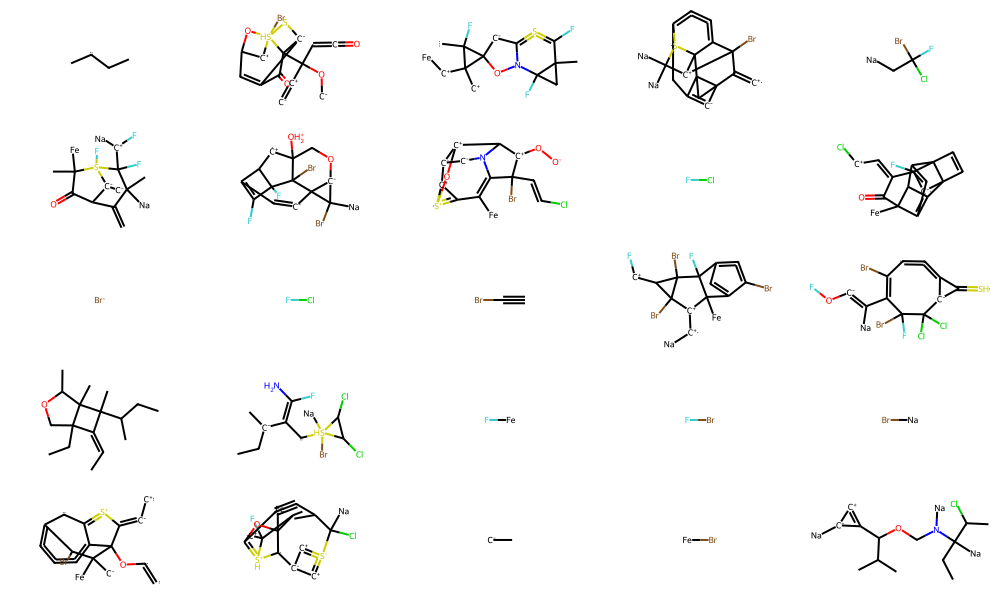

In [14]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120))#, legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

In [35]:
#ea.Tags()

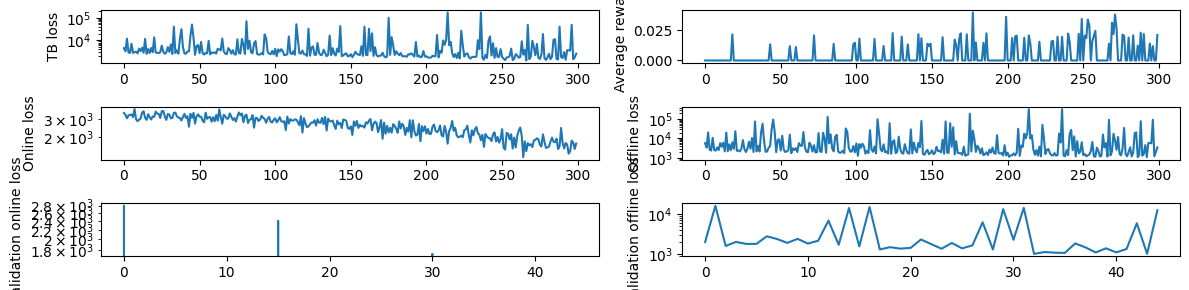

In [15]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(3, 2, figsize=(4*3,3))
ax[0,0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
ax[0,1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[0,1].set_ylabel('Average reward')
#ax[0,2].plot([i.value for i in ea.Scalars('train_logZ')])
#ax[0,2].set_ylabel('Predicted logZ')
ax[1,0].plot([i.value for i in ea.Scalars('train_online_loss')])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
ax[1,1].plot([i.value for i in ea.Scalars('train_offline_loss')])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
ax[2,0].plot([i.value for i in ea.Scalars('valid_online_loss')])
ax[2,0].set_yscale('log')
ax[2,0].set_ylabel('Validation online loss')
ax[2,1].plot([i.value for i in ea.Scalars('valid_offline_loss')])
ax[2,1].set_yscale('log')
ax[2,1].set_ylabel('Validation offline loss')
pp.tight_layout()

In [31]:
max([i.value for i in ea.Scalars('train_sampled_reward_avg')])

0.7858443856239319

In [ ]:
cfg.log_dir+"/train/"

'./logs/dataload_2/train'

In [ ]:
!dir ./logs/dataload_2/train/

Parameter format not correct - "logs".


In [16]:
import sqlite3
import pandas as pd
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [17]:
conn = sqlite3.connect(f"{cfg.log_dir}/train/generated_objs_0.db")

In [18]:
df = pd.read_sql_query("SELECT * FROM results", conn)

In [19]:
import numpy as np

In [25]:
idx_list = sorted([j*32 -i -1  for j in [50,100,150,200,300] for i in range(5)])

In [26]:
choosendf = df.iloc[idx_list]

In [23]:
top_rewards = df.sort_values(by='r', ascending=False).head(25)


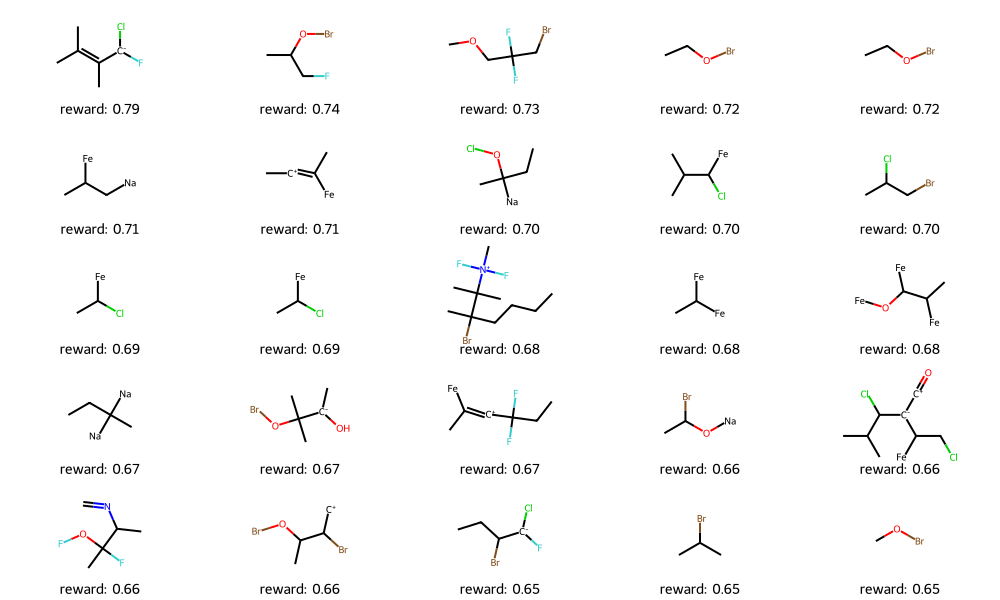

In [24]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]
rewards = top_rewards["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

In [27]:
df['iteration'] = df.index // 32

# Compute mean of desired columns per iteration
# Example: mean reward per iteration
# Replace 'reward' with your actual column name
mean_per_iter = df.groupby('iteration')['r'].mean()
mean_per_iter

iteration
0      1.000000e-30
1      1.000000e-30
2      1.000000e-30
3      1.000000e-30
4      1.000000e-30
           ...     
295    1.000000e-30
296    1.188925e-02
297    1.000000e-30
298    1.000000e-30
299    2.112544e-02
Name: r, Length: 300, dtype: float64

In [28]:
import matplotlib.pyplot as plt

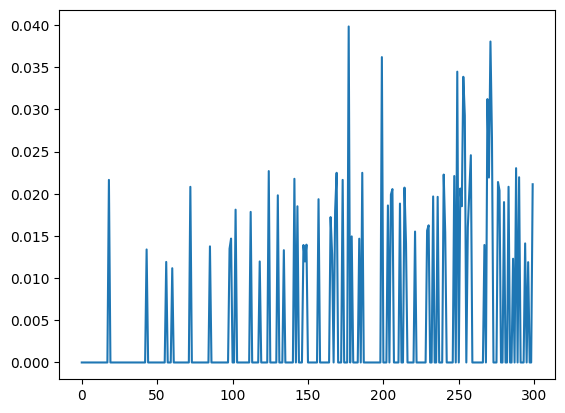

In [29]:
plt.plot(mean_per_iter)

In [30]:
from rdkit import Chem

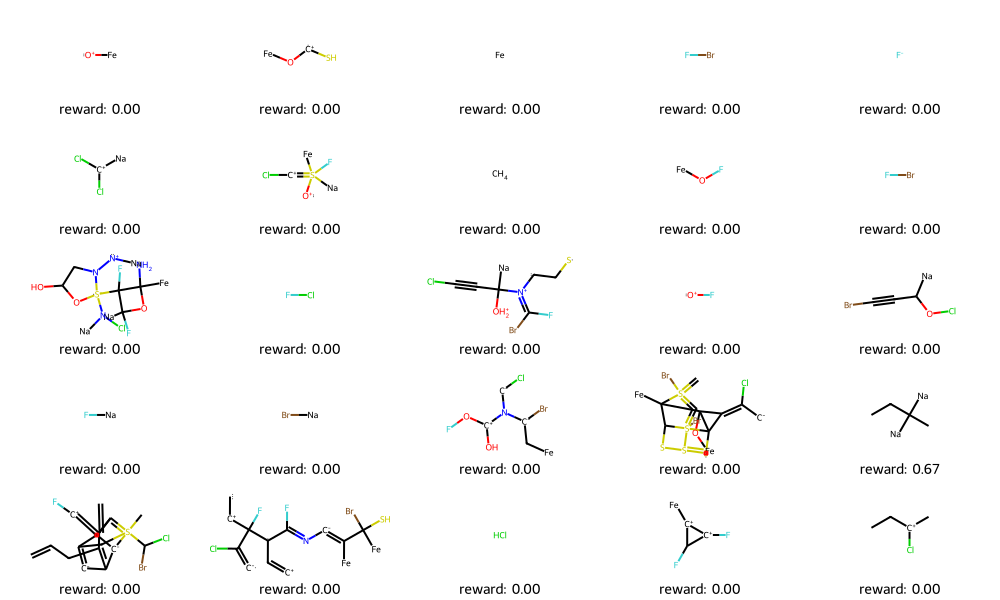

In [31]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in choosendf["smi"]]
rewards = choosendf["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[10], line 23
     18 config.overwrite_existing_exp=True
     22 trial = ScentTrainer(config)
---> 23 trial.run()
     24 save_run(trial)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:271, in GFNTrainer.run(self, logger)
    269 logger.info("Starting training")
    270 start_time = time.time()
--> 271 for it, batch in zip(range(start, 1 + num_training_steps), cycle(train_dl)):
    272     # the memory fragmentation or allocation keeps growing, how often should we clean up?
    273     # is changing the allocation strategy helpful?
    275     if it % 1024 == 0:
    276         gc.collect()

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:377, in cycle(it)
    375 def cycle(it):
    376     while True:
--> 377         for i in it:
    378             yield i

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:708, in _BaseDataLoaderIter.__next__(self)
    705 if self._sampler_iter is None:
    706     # TODO(https://github.com/pytorch/pytorch/issues/76750)
    707     self._reset()  # type: ignore[call-arg]
--> 708 data = self._next_data()
    709 self._num_yielded += 1
    710 if (
    711     self._dataset_kind == _DatasetKind.Iterable
    712     and self._IterableDataset_len_called is not None
    713     and self._num_yielded > self._IterableDataset_len_called
    714 ):

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:764, in _SingleProcessDataLoaderIter._next_data(self)
    762 def _next_data(self):
    763     index = self._next_index()  # may raise StopIteration
--> 764     data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    765     if self._pin_memory:
    766         data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\_utils\fetch.py:42, in _IterableDatasetFetcher.fetch(self, possibly_batched_index)
     40         raise StopIteration
     41 else:
---> 42     data = next(self.dataset_iter)
     43 return self.collate_fn(data)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:80, in DataSource.__iter__(self)
     78 for d in batch_infos:
     79     batch_info.update(d)
---> 80 yield self.create_batch(trajs, batch_info)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:220, in DataSource.create_batch(self, trajs, batch_info)
    218 ci = torch.stack([t["cond_info"]["encoding"] for t in trajs])
    219 log_rewards = torch.stack([t["log_reward"] for t in trajs])
--> 220 batch = self.algo.construct_batch(trajs, ci, log_rewards)
    221 batch.num_online = sum(t.get("is_online", 0) for t in trajs)
    222 batch.num_offline = len(trajs) - batch.num_online

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in TrajectoryBalance.construct_batch(self, trajs, cond_info, log_rewards)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in <listcomp>(.0)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\envs\mol_building_env.py:280, in MolBuildingEnvContext.graph_to_Data(self, g)
    277     remove_node_mask[i] = 1
    278 for k, sl in zip(self.atom_attrs, self.atom_attr_slice):
    279     # idx > 0 means that the attribute is not the default value
--> 280     idx = self.atom_attr_values[k].index(ad[k]) if k in ad else 0
    281     x[i, sl + idx] = 1
    282     if k == "v":

ValueError: 1 is not in list